In [2]:
"""
This code establishes the framework for implementing and evaluating deep neural networks for 
reactivity ratio prediction in heteropolymerization. 
"""
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import random
from sklearn.metrics import r2_score



In [3]:
"""
This code loads the heteropolymerization dataset containing monomer pairs, their reactivity ratios,
and cluster assignments from spectral clustering. Adds log10-transformed versions of r1 and r2.
"""
import numpy as np
import pandas as pd

# Load the main DataFrame
df = pd.read_excel(r'/work/bavarian/hsafari2/ClusteringProject (Start: Winter2024)/Revised code/AddedFeaturesWithClusters.xlsx')

# Round original values
df['r1'] = df['r1'].round(2)
df['r2'] = df['r2'].round(2)

# Add log10-transformed columns (handle zeros and negative values)
epsilon = 1e-8  # Small value to avoid log(0)

# Create log10-transformed versions (using log10, not natural log)
df['r1_log'] = np.log10(df['r1'] )
df['r2_log'] = np.log10(df['r2'] )

# Display statistics to see the transformation effect
print("=== Comparison of Original vs Log10-Transformed Data ===")
print(f"\nOriginal r1 - Mean: {df['r1'].mean():.3f}, Std: {df['r1'].std():.3f}, Skewness: {df['r1'].skew():.3f}")
print(f"Log10 r1    - Mean: {df['r1_log'].mean():.3f}, Std: {df['r1_log'].std():.3f}, Skewness: {df['r1_log'].skew():.3f}")
print(f"\nOriginal r2 - Mean: {df['r2'].mean():.3f}, Std: {df['r2'].std():.3f}, Skewness: {df['r2'].skew():.3f}")
print(f"Log10 r2    - Mean: {df['r2_log'].mean():.3f}, Std: {df['r2_log'].std():.3f}, Skewness: {df['r2_log'].skew():.3f}")

print(f"\nDataset shape: {df.shape}")
print(f"All columns: {list(df.columns)}")

# Display the complete dataframe
display(df)

=== Comparison of Original vs Log10-Transformed Data ===

Original r1 - Mean: 0.950, Std: 1.374, Skewness: 3.242
Log10 r1    - Mean: -0.372, Std: 0.607, Skewness: -0.449

Original r2 - Mean: 0.950, Std: 1.374, Skewness: 3.242
Log10 r2    - Mean: -0.372, Std: 0.607, Skewness: -0.449

Dataset shape: (2304, 38)
All columns: ['SMILES_A', 'SMILES_B', 'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B', 'MV_A', 'MV_B', 'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHAcceptors_A', 'NumHAcceptors_B', 'NumHDonors_A', 'NumHDonors_B', 'MolLogP_A', 'MolLogP_B', 'Hybridization_sp_A', 'Hybridization_sp_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B', 'Hybridization_sp3_A', 'Hybridization_sp3_B', 'Chirality_A', 'Chirality_B', 'NumConnectedHydrogens_A', 'NumConnectedHydrogens_B', 'ConjugatedBonds_A', 'ConjugatedBonds_B', 'Stereochemistry_A', 'Stereochemistry_B', 'Cluster_A', 'Cluster_B', 'r1', 'r2', 'r1_log', 'r2_log']


SMILES_A            SMILES_B  vinylIsInLoop_A  vinylIsInLoop_B  \
0       CC(=C)C(=O)O           C=C(Cl)Cl                0                0   
1          C=C(Cl)Cl        CC(=C)C(=O)O                0                0   
2       CC(=C)C(=O)O      CCOC(=O)C(=C)C                0                0   
3     CCOC(=O)C(=C)C        CC(=C)C(=O)O                0                0   
4       CC(=C)C(=O)O  CC(C)COC(=O)C(=C)C                0                0   
...              ...                 ...              ...              ...   
2299  C=CC1=CC=CC=C1            C=CN=C=S                0                0   
2300     CC(=C)N=C=O          COC(=O)C=C                0                0   
2301      COC(=O)C=C         CC(=C)N=C=O                0                0   
2302     CC(=C)N=C=O      C=CC1=CC=CC=C1                0                0   
2303  C=CC1=CC=CC=C1         CC(=C)N=C=O                0                0   

      VinylCarbonsCharge_A  VinylCarbonsCharge_B     MV_A     MV_B     MW_A  \
0                -0.062175              0.030563   84.360   70.160   86.090   
1                 0.030563             -0.062175   70.160   84.360   96.944   
2                -0.062175             -0.061991   84.344  118.208   86.090   
3                -0.061991             -0.062175  117.992   84.240  114.144   
4                -0.062175             -0.061991   84.360  151.856   86.090   
...                    ...                   ...      ...      ...      ...   
2299             -0.160678             -0.049227  111.688   75.864  104.152   
2300             -0.033376             -0.075811   82.104   84.680   83.090   
2301             -0.075811             -0.033376   84.816   82.152   86.090   
2302             -0.033376             -0.160678   82.040  111.720   83.090   
2303             -0.160678             -0.033376  111.448   82.032  104.152   

         MW_B  ...  ConjugatedBonds_A  ConjugatedBonds_B  Stereochemistry_A  \
0      96.944  ...                  4                  0                  0   
1      86.090  ...                  0                  4                  0   
2     114.144  ...                  4                  4                  0   
3      86.090  ...                  4                  4                  0   
4     142.198  ...                  4                  4                  0   
...       ...  ...                ...                ...                ...   
2299   85.131  ...                  8                  4                  0   
2300   86.090  ...                  4                  4                  0   
2301   83.090  ...                  4                  4                  0   
2302  104.152  ...                  4                  8                  0   
2303   83.090  ...                  8                  4                  0   

      Stereochemistry_B  Cluster_A  Cluster_B    r1    r2    r1_log    r2_log  
0                     0          1          1  3.37  0.15  0.527630 -0.823909  
1                     0          1          1  0.15  3.37 -0.823909  0.527630  
2                     0          1          1  0.57  0.71 -0.244125 -0.148742  
3                     0          1          1  0.71  0.57 -0.148742 -0.244125  
4                     0          1          1  2.01  0.47  0.303196 -0.327902  
...                 ...        ...        ...   ...   ...       ...       ...  
2299                  0          2          1  0.73  0.44 -0.136677 -0.356547  
2300                  0          1          1  0.09  0.70 -1.045757 -0.154902  
2301                  0          1          1  0.70  0.09 -0.154902 -1.045757  
2302                  0          1          2  0.10  7.48 -1.000000  0.873902  
2303                  0          2          1  7.48  0.10  0.873902 -1.000000  

[2304 rows x 38 columns]

In [3]:
# ============================================================================
# CONFIGURATION - Easy to modify hyperparameters
# ============================================================================
HIDDEN_LAYERS = [80, 40]        # Architecture: [80, 40] or [100, 50, 10] or [70] etc.
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 400
PATIENCE = 50                   # Early stopping patience
MORGAN_RADIUS = 3
MORGAN_BITS = 2048
VALIDATION_SPLIT = 0.1
CV_FOLDS = 10
RANDOM_SEED = 42

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("=== CONFIGURATION ===")
print(f"Architecture: {HIDDEN_LAYERS}")
print(f"Learning Rate: {LEARNING_RATE}, Batch Size: {BATCH_SIZE}")
print(f"Morgan FP: {MORGAN_BITS} bits, Radius: {MORGAN_RADIUS}")
print(f"CV Folds: {CV_FOLDS}")

# ============================================================================
# DATA LOADING & PREPROCESSING
# ============================================================================
print("\n=== DATA PREPROCESSING ===")

# Filter data for quality
data = df.copy()
initial_size = len(data)

# Remove invalid entries
data = data[(data['r1'] > 0) & (data['r2'] > 0)]
data = data[(data['r1'] >= 0.01) & (data['r1'] <= 100)]
data = data[(data['r2'] >= 0.01) & (data['r2'] <= 100)]
data = data.dropna(subset=['SMILES_A', 'SMILES_B', 'r1_log', 'r2_log'])

print(f"Data filtered: {initial_size} → {len(data)} samples")

# Prepare targets (log scale for training)
y_log = data[['r1_log', 'r2_log']].values
y_actual = data[['r1', 'r2']].values

print(f"Target shape: {y_log.shape}")

# ============================================================================
# MORGAN FINGERPRINT GENERATION
# ============================================================================
print("\n=== MORGAN FINGERPRINT GENERATION ===")

def get_morgan_fp(smiles):
    """Convert SMILES to Morgan fingerprint"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS, dtype=np.float32)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, MORGAN_RADIUS, nBits=MORGAN_BITS)
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(MORGAN_BITS, dtype=np.float32)

# Generate Morgan fingerprints for both monomers
print("Generating Morgan fingerprints...")
fps_A = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_A']])
fps_B = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_B']])

# Concatenate fingerprints [Morgan_A + Morgan_B]
X = np.concatenate([fps_A, fps_B], axis=1)

print(f"Morgan FP A: {fps_A.shape}")
print(f"Morgan FP B: {fps_B.shape}")
print(f"Final input X: {X.shape}")

# ============================================================================
# MODEL BUILDING FUNCTION
# ============================================================================
def create_model(input_dim, hidden_layers, loss_weights=[0.5, 0.5]):
    """Create dynamic FCNN architecture with custom loss weighting"""
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)))
    
    # Additional hidden layers
    for neurons in hidden_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
    
    # Output layer (2 neurons for log r1, log r2)
    model.add(Dense(2, activation='linear'))
    
    # Custom weighted MSE loss
    def weighted_mse(y_true, y_pred):
        mse_r1 = tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0]))
        mse_r2 = tf.reduce_mean(tf.square(y_true[:, 1] - y_pred[:, 1]))
        return loss_weights[0] * mse_r1 + loss_weights[1] * mse_r2
    
    # Compile model with custom loss
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=weighted_mse
    )
    
    return model

# ============================================================================
# METRICS CALCULATION FUNCTIONS
# ============================================================================
def calculate_metrics(y_true_log, y_pred_log):
    """Calculate comprehensive metrics for both log and actual scales"""
    # Log scale metrics
    mse_log_r1 = np.mean((y_true_log[:, 0] - y_pred_log[:, 0])**2)
    mse_log_r2 = np.mean((y_true_log[:, 1] - y_pred_log[:, 1])**2)
    mae_log_r1 = np.mean(np.abs(y_true_log[:, 0] - y_pred_log[:, 0]))
    mae_log_r2 = np.mean(np.abs(y_true_log[:, 1] - y_pred_log[:, 1]))
    r2_log_r1 = r2_score(y_true_log[:, 0], y_pred_log[:, 0])
    r2_log_r2 = r2_score(y_true_log[:, 1], y_pred_log[:, 1])
    
    # Convert to actual scale
    y_true_actual = 10**y_true_log
    y_pred_actual = 10**y_pred_log
    
    # Actual scale metrics
    mse_actual_r1 = np.mean((y_true_actual[:, 0] - y_pred_actual[:, 0])**2)
    mse_actual_r2 = np.mean((y_true_actual[:, 1] - y_pred_actual[:, 1])**2)
    mae_actual_r1 = np.mean(np.abs(y_true_actual[:, 0] - y_pred_actual[:, 0]))
    mae_actual_r2 = np.mean(np.abs(y_true_actual[:, 1] - y_pred_actual[:, 1]))
    r2_actual_r1 = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])
    r2_actual_r2 = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])
    
    return {
        'mse_log_r1': mse_log_r1, 'mse_log_r2': mse_log_r2,
        'mae_log_r1': mae_log_r1, 'mae_log_r2': mae_log_r2,
        'r2_log_r1': r2_log_r1, 'r2_log_r2': r2_log_r2,
        'mse_actual_r1': mse_actual_r1, 'mse_actual_r2': mse_actual_r2,
        'mae_actual_r1': mae_actual_r1, 'mae_actual_r2': mae_actual_r2,
        'r2_actual_r1': r2_actual_r1, 'r2_actual_r2': r2_actual_r2
    }

# ============================================================================
# 10-FOLD CROSS VALIDATION
# ============================================================================
print(f"\n=== 10-FOLD CROSS VALIDATION ===")
print(f"Architecture: {HIDDEN_LAYERS}")

from sklearn.model_selection import KFold

# Initialize storage for all fold results
all_results = []

# Initialize storage for predictions (for parity plots)
all_train_predictions = {'y_true': [], 'y_pred': []}
all_test_predictions = {'y_true': [], 'y_pred': []}

# Set up cross-validation
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation
for fold_num, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold_num + 1}/{CV_FOLDS}")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_log, y_test_log = y_log[train_idx], y_log[test_idx]
    
    # Clear Keras session
    tf.keras.backend.clear_session()
    
    # Create and train model
    model = create_model(X.shape[1], HIDDEN_LAYERS)
    
    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=PATIENCE, 
        restore_best_weights=True, 
        verbose=0
    )
    
    # Train model
    history = model.fit(
        X_train, y_train_log,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Make predictions
    y_train_pred_log = model.predict(X_train, verbose=0)
    y_test_pred_log = model.predict(X_test, verbose=0)
    
    # Store predictions for parity plots
    all_train_predictions['y_true'].append(y_train_log)
    all_train_predictions['y_pred'].append(y_train_pred_log)
    all_test_predictions['y_true'].append(y_test_log)
    all_test_predictions['y_pred'].append(y_test_pred_log)
    
    # Calculate metrics for training set
    train_metrics = calculate_metrics(y_train_log, y_train_pred_log)
    
    # Calculate metrics for test set
    test_metrics = calculate_metrics(y_test_log, y_test_pred_log)
    
    # Store results
    fold_result = {
        'fold': fold_num + 1,
        # Training metrics
        'train_mse_log_r1': train_metrics['mse_log_r1'],
        'train_mse_log_r2': train_metrics['mse_log_r2'],
        'train_mae_log_r1': train_metrics['mae_log_r1'],
        'train_mae_log_r2': train_metrics['mae_log_r2'],
        'train_r2_log_r1': train_metrics['r2_log_r1'],
        'train_r2_log_r2': train_metrics['r2_log_r2'],
        'train_mse_actual_r1': train_metrics['mse_actual_r1'],
        'train_mse_actual_r2': train_metrics['mse_actual_r2'],
        'train_mae_actual_r1': train_metrics['mae_actual_r1'],
        'train_mae_actual_r2': train_metrics['mae_actual_r2'],
        'train_r2_actual_r1': train_metrics['r2_actual_r1'],
        'train_r2_actual_r2': train_metrics['r2_actual_r2'],
        # Test metrics
        'test_mse_log_r1': test_metrics['mse_log_r1'],
        'test_mse_log_r2': test_metrics['mse_log_r2'],
        'test_mae_log_r1': test_metrics['mae_log_r1'],
        'test_mae_log_r2': test_metrics['mae_log_r2'],
        'test_r2_log_r1': test_metrics['r2_log_r1'],
        'test_r2_log_r2': test_metrics['r2_log_r2'],
        'test_mse_actual_r1': test_metrics['mse_actual_r1'],
        'test_mse_actual_r2': test_metrics['mse_actual_r2'],
        'test_mae_actual_r1': test_metrics['mae_actual_r1'],
        'test_mae_actual_r2': test_metrics['mae_actual_r2'],
        'test_r2_actual_r1': test_metrics['r2_actual_r1'],
        'test_r2_actual_r2': test_metrics['r2_actual_r2']
    }
    
    all_results.append(fold_result)
    
    # Print fold summary
    print(f"  Train R² (log): r1={train_metrics['r2_log_r1']:.3f}, r2={train_metrics['r2_log_r2']:.3f}")
    print(f"  Test R² (log):  r1={test_metrics['r2_log_r1']:.3f}, r2={test_metrics['r2_log_r2']:.3f}")

# Combine all predictions for parity plots
train_y_true_combined = np.vstack(all_train_predictions['y_true'])
train_y_pred_combined = np.vstack(all_train_predictions['y_pred'])
test_y_true_combined = np.vstack(all_test_predictions['y_true'])
test_y_pred_combined = np.vstack(all_test_predictions['y_pred'])

print(f"\nCombined predictions for parity plots:")
print(f"  Train: {train_y_true_combined.shape}")
print(f"  Test: {test_y_true_combined.shape}")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("FINAL RESULTS - MEAN ± STANDARD DEVIATION")
print(f"{'='*80}")

# Convert results to DataFrame for easy statistics
results_df = pd.DataFrame(all_results)

print(f"\nARCHITECTURE: {HIDDEN_LAYERS}")
print(f"TOTAL PARAMETERS: {sum(HIDDEN_LAYERS) + sum([HIDDEN_LAYERS[i]*HIDDEN_LAYERS[i+1] for i in range(len(HIDDEN_LAYERS)-1)]) + X.shape[1]*HIDDEN_LAYERS[0] + HIDDEN_LAYERS[-1]*2}")

print(f"\nLOG SCALE RESULTS:")
print(f"{'─'*50}")
for metric in ['train_mse_log_r1', 'train_mse_log_r2', 'test_mse_log_r1', 'test_mse_log_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

print(f"\n")
for metric in ['train_r2_log_r1', 'train_r2_log_r2', 'test_r2_log_r1', 'test_r2_log_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

print(f"\nACTUAL SCALE RESULTS:")
print(f"{'─'*50}")
for metric in ['train_mse_actual_r1', 'train_mse_actual_r2', 'test_mse_actual_r1', 'test_mse_actual_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

print(f"\n")
for metric in ['train_r2_actual_r1', 'train_r2_actual_r2', 'test_r2_actual_r1', 'test_r2_actual_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

# Save detailed results
#results_df.to_csv('cv_results_detailed.csv', index=False)
print(f"\nDetailed results saved to 'cv_results_detailed.csv'")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")

=== CONFIGURATION ===
Architecture: [80, 40]
Learning Rate: 0.001, Batch Size: 32
Morgan FP: 2048 bits, Radius: 3
CV Folds: 10

=== DATA PREPROCESSING ===
Data filtered: 2304 → 2304 samples
Target shape: (2304, 2)

=== MORGAN FINGERPRINT GENERATION ===
Generating Morgan fingerprints...
Morgan FP A: (2304, 2048)
Morgan FP B: (2304, 2048)
Final input X: (2304, 4096)

=== 10-FOLD CROSS VALIDATION ===
Architecture: [80, 40]

Fold 1/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-07 14:49:02.663816: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  Train R² (log): r1=0.936, r2=0.940
  Test R² (log):  r1=0.372, r2=0.492

Fold 2/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.905, r2=0.910
  Test R² (log):  r1=0.464, r2=0.526

Fold 3/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.927, r2=0.941
  Test R² (log):  r1=0.541, r2=0.518

Fold 4/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.939, r2=0.908
  Test R² (log):  r1=0.519, r2=0.510

Fold 5/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.928, r2=0.921
  Test R² (log):  r1=0.432, r2=0.422

Fold 6/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.913, r2=0.902
  Test R² (log):  r1=0.407, r2=0.459

Fold 7/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.897, r2=0.863
  Test R² (log):  r1=0.454, r2=0.334

Fold 8/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.840, r2=0.849
  Test R² (log):  r1=0.503, r2=0.451

Fold 9/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.911, r2=0.928
  Test R² (log):  r1=0.445, r2=0.592

Fold 10/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.902, r2=0.875
  Test R² (log):  r1=0.467, r2=0.417

Combined predictions for parity plots:
  Train: (20736, 2)
  Test: (2304, 2)

FINAL RESULTS - MEAN ± STANDARD DEVIATION

ARCHITECTURE: [80, 40]
TOTAL PARAMETERS: 331080

LOG SCALE RESULTS:
──────────────────────────────────────────────────
Train Mse Log R1: 0.0332 ± 0.0104
Train Mse Log R2: 0.0354 ± 0.0114
Test Mse Log R1: 0.1972 ± 0.0163
Test Mse Log R2: 0.1929 ± 0.0356


Train R2 Log R1: 0.9099 ± 0.0284
Train R2 Log R2: 0.9036 ± 0.0316
Test R2 Log R1: 0.4606 ± 0.0513
Test R2 Log R2: 0.4723 ± 0.0717

ACTUAL SCALE RESULTS:
──────────────────────────────────────────────────
Train Mse Actual R1: 0.3672 ± 0.1078
Train Mse Actual R2: 0.3645 ± 0.1241
Test Mse Actual R1: 1.4960 ± 0.3390
Test Mse Actual R2: 1.4100 ± 0.4574


Train R2 Actual R1: 0.8052 ± 0.0575
Train R2 Actual R2: 0.8072 ± 0.0636
Test R2 Actual R1: 0.1930 ± 0.0701
Test R2 Actual R2: 0.2463 ± 0.0663

Detailed results saved to 'cv_results_detailed.csv'

A

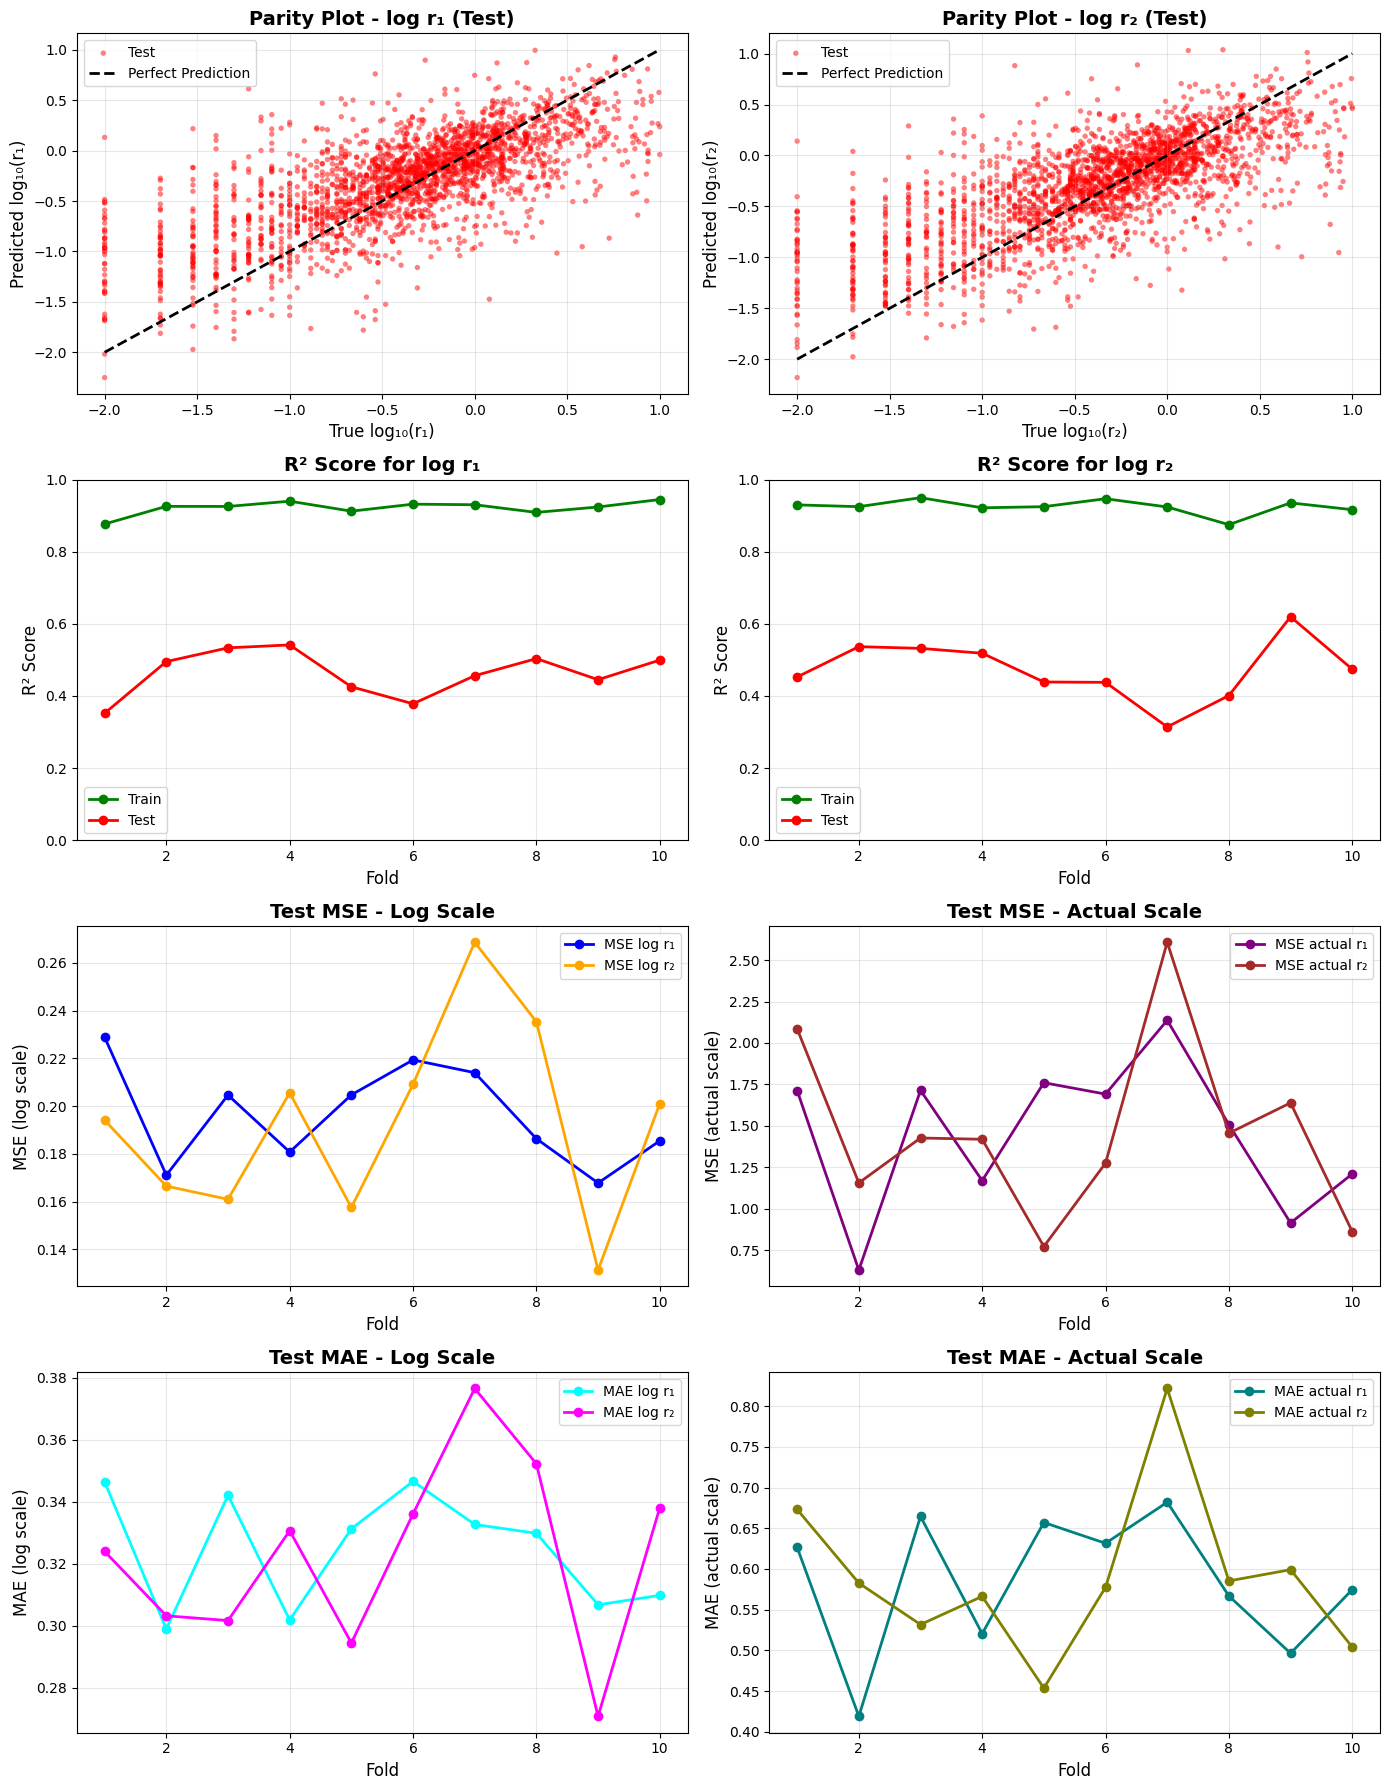

Comprehensive visualization complete!


In [35]:
# ============================================================================
# VISUALIZATION - 4x2 subplot layout with parity plots, R², MSE, and MAE
# ============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(14, 18))

# Extract fold numbers for x-axis
folds = results_df['fold'].values

# ===========================================================================
# ROW 1: PARITY PLOTS (Predicted vs True) - TEST DATA ONLY
# ===========================================================================

# Row 1, Column 1: Parity plot for log r1 (test only)
axes[0, 0].scatter(test_y_true_combined[:, 0], test_y_pred_combined[:, 0], 
                   alpha=0.5, s=15, color='red', label='Test', edgecolors='none')
# Diagonal line (perfect prediction)
min_val = test_y_true_combined[:, 0].min()
max_val = test_y_true_combined[:, 0].max()
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('True log₁₀(r₁)', fontsize=12)
axes[0, 0].set_ylabel('Predicted log₁₀(r₁)', fontsize=12)
axes[0, 0].set_title('Parity Plot - log r₁ (Test)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Row 1, Column 2: Parity plot for log r2 (test only)
axes[0, 1].scatter(test_y_true_combined[:, 1], test_y_pred_combined[:, 1], 
                   alpha=0.5, s=15, color='red', label='Test', edgecolors='none')
# Diagonal line
min_val = test_y_true_combined[:, 1].min()
max_val = test_y_true_combined[:, 1].max()
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('True log₁₀(r₂)', fontsize=12)
axes[0, 1].set_ylabel('Predicted log₁₀(r₂)', fontsize=12)
axes[0, 1].set_title('Parity Plot - log r₂ (Test)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# ===========================================================================
# ROW 2: R² SCORES
# ===========================================================================

# Row 2, Column 1: R² for log r1
axes[1, 0].plot(folds, results_df['train_r2_log_r1'], 'o-', color='green', label='Train', linewidth=2, markersize=6)
axes[1, 0].plot(folds, results_df['test_r2_log_r1'], 'o-', color='red', label='Test', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Fold', fontsize=12)
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('R² Score for log r₁', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Row 2, Column 2: R² for log r2
axes[1, 1].plot(folds, results_df['train_r2_log_r2'], 'o-', color='green', label='Train', linewidth=2, markersize=6)
axes[1, 1].plot(folds, results_df['test_r2_log_r2'], 'o-', color='red', label='Test', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Fold', fontsize=12)
axes[1, 1].set_ylabel('R² Score', fontsize=12)
axes[1, 1].set_title('R² Score for log r₂', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

# ===========================================================================
# ROW 3: MSE
# ===========================================================================

# Row 3, Column 1: MSE for log scale (both r1 and r2)
axes[2, 0].plot(folds, results_df['test_mse_log_r1'], 'o-', color='blue', label='MSE log r₁', linewidth=2, markersize=6)
axes[2, 0].plot(folds, results_df['test_mse_log_r2'], 'o-', color='orange', label='MSE log r₂', linewidth=2, markersize=6)
axes[2, 0].set_xlabel('Fold', fontsize=12)
axes[2, 0].set_ylabel('MSE (log scale)', fontsize=12)
axes[2, 0].set_title('Test MSE - Log Scale', fontsize=14, fontweight='bold')
axes[2, 0].legend(fontsize=10)
axes[2, 0].grid(True, alpha=0.3)

# Row 3, Column 2: MSE for actual scale (both r1 and r2)
axes[2, 1].plot(folds, results_df['test_mse_actual_r1'], 'o-', color='purple', label='MSE actual r₁', linewidth=2, markersize=6)
axes[2, 1].plot(folds, results_df['test_mse_actual_r2'], 'o-', color='brown', label='MSE actual r₂', linewidth=2, markersize=6)
axes[2, 1].set_xlabel('Fold', fontsize=12)
axes[2, 1].set_ylabel('MSE (actual scale)', fontsize=12)
axes[2, 1].set_title('Test MSE - Actual Scale', fontsize=14, fontweight='bold')
axes[2, 1].legend(fontsize=10)
axes[2, 1].grid(True, alpha=0.3)

# ===========================================================================
# ROW 4: MAE (Mean Absolute Error)
# ===========================================================================

# Row 4, Column 1: MAE for log scale (both r1 and r2)
axes[3, 0].plot(folds, results_df['test_mae_log_r1'], 'o-', color='cyan', label='MAE log r₁', linewidth=2, markersize=6)
axes[3, 0].plot(folds, results_df['test_mae_log_r2'], 'o-', color='magenta', label='MAE log r₂', linewidth=2, markersize=6)
axes[3, 0].set_xlabel('Fold', fontsize=12)
axes[3, 0].set_ylabel('MAE (log scale)', fontsize=12)
axes[3, 0].set_title('Test MAE - Log Scale', fontsize=14, fontweight='bold')
axes[3, 0].legend(fontsize=10)
axes[3, 0].grid(True, alpha=0.3)

# Row 4, Column 2: MAE for actual scale (both r1 and r2)
axes[3, 1].plot(folds, results_df['test_mae_actual_r1'], 'o-', color='teal', label='MAE actual r₁', linewidth=2, markersize=6)
axes[3, 1].plot(folds, results_df['test_mae_actual_r2'], 'o-', color='olive', label='MAE actual r₂', linewidth=2, markersize=6)
axes[3, 1].set_xlabel('Fold', fontsize=12)
axes[3, 1].set_ylabel('MAE (actual scale)', fontsize=12)
axes[3, 1].set_title('Test MAE - Actual Scale', fontsize=14, fontweight='bold')
axes[3, 1].legend(fontsize=10)
axes[3, 1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('comprehensive_cv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comprehensive visualization complete!")

In [31]:
# ============================================================================
# CONFIGURATION - Easy to modify hyperparameters
# ============================================================================
HIDDEN_LAYERS = [1024, 512, 256, 128, 64]        # Architecture: [80, 40] or [100, 50, 10] or [70] etc.
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 400
PATIENCE = 50                   # Early stopping patience
MORGAN_RADIUS = 3
MORGAN_BITS = 2048
VALIDATION_SPLIT = 0.1
CV_FOLDS = 10
RANDOM_SEED = 42

# CLUSTER FILTERING - Set to None to use all data, or specify cluster numbers
CLUSTER_A = 1  # Set to None for no filtering, or 1, 2, 3 for specific cluster
CLUSTER_B = 2  # Set to None for no filtering, or 1, 2, 3 for specific cluster

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("=== CONFIGURATION ===")
print(f"Architecture: {HIDDEN_LAYERS}")
print(f"Learning Rate: {LEARNING_RATE}, Batch Size: {BATCH_SIZE}")
print(f"Morgan FP: {MORGAN_BITS} bits, Radius: {MORGAN_RADIUS}")
print(f"CV Folds: {CV_FOLDS}")
if CLUSTER_A is not None or CLUSTER_B is not None:
    print(f"Cluster Filter: C{CLUSTER_A} - C{CLUSTER_B}")
else:
    print("Cluster Filter: None (using all data)")

# ============================================================================
# DATA LOADING & PREPROCESSING
# ============================================================================
print("\n=== DATA PREPROCESSING ===")

# Filter data for quality
data = df.copy()
initial_size = len(data)

# Remove invalid entries
data = data[(data['r1'] > 0) & (data['r2'] > 0)]
data = data[(data['r1'] >= 0.01) & (data['r1'] <= 100)]
data = data[(data['r2'] >= 0.01) & (data['r2'] <= 100)]
data = data.dropna(subset=['SMILES_A', 'SMILES_B', 'r1_log', 'r2_log'])

print(f"Data filtered: {initial_size} → {len(data)} samples")

# Apply cluster filtering if specified
if CLUSTER_A is not None and CLUSTER_B is not None:
    # Filter for symmetric cluster interactions (order doesn't matter)
    cluster_mask = (
        ((data['Cluster_A'] == CLUSTER_A) & (data['Cluster_B'] == CLUSTER_B)) |
        ((data['Cluster_A'] == CLUSTER_B) & (data['Cluster_B'] == CLUSTER_A))
    )
    data = data[cluster_mask].copy()
    print(f"\n{'='*80}")
    print(f"CLUSTER FILTERING: C{CLUSTER_A}-C{CLUSTER_B} INTERACTION")
    print(f"{'='*80}")
    print(f"Filtered dataset size: {len(data)} samples")
    print(f"This includes both (C{CLUSTER_A},C{CLUSTER_B}) and (C{CLUSTER_B},C{CLUSTER_A}) pairs")
    print(f"{'='*80}\n")
elif CLUSTER_A is not None and CLUSTER_B is None:
    # Filter for self-interaction only
    cluster_mask = (data['Cluster_A'] == CLUSTER_A) & (data['Cluster_B'] == CLUSTER_A)
    data = data[cluster_mask].copy()
    print(f"\n{'='*80}")
    print(f"CLUSTER FILTERING: C{CLUSTER_A}-C{CLUSTER_A} SELF-INTERACTION")
    print(f"{'='*80}")
    print(f"Filtered dataset size: {len(data)} samples")
    print(f"{'='*80}\n")

# Check if we have enough data
if len(data) < 100:
    print(f"WARNING: Only {len(data)} samples available. This may be too small for robust 10-fold CV.")
    print("Consider using fewer folds or combining with other cluster interactions.\n")

# Prepare targets (log scale for training)
y_log = data[['r1_log', 'r2_log']].values
y_actual = data[['r1', 'r2']].values

print(f"Target shape: {y_log.shape}")

# ============================================================================
# MORGAN FINGERPRINT GENERATION
# ============================================================================
print("\n=== MORGAN FINGERPRINT GENERATION ===")

def get_morgan_fp(smiles):
    """Convert SMILES to Morgan fingerprint"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS, dtype=np.float32)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, MORGAN_RADIUS, nBits=MORGAN_BITS)
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(MORGAN_BITS, dtype=np.float32)

# Generate Morgan fingerprints for both monomers
print("Generating Morgan fingerprints...")
fps_A = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_A']])
fps_B = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_B']])

# Concatenate fingerprints [Morgan_A + Morgan_B]
X = np.concatenate([fps_A, fps_B], axis=1)

print(f"Morgan FP A: {fps_A.shape}")
print(f"Morgan FP B: {fps_B.shape}")
print(f"Final input X: {X.shape}")

# ============================================================================
# MODEL BUILDING FUNCTION
# ============================================================================
def create_model(input_dim, hidden_layers, loss_weights=[0.5, 0.5]):
    """Create dynamic FCNN architecture with custom loss weighting"""
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)))
    
    # Additional hidden layers
    for neurons in hidden_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
    
    # Output layer (2 neurons for log r1, log r2)
    model.add(Dense(2, activation='linear'))
    
    # Custom weighted MSE loss
    def weighted_mse(y_true, y_pred):
        mse_r1 = tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0]))
        mse_r2 = tf.reduce_mean(tf.square(y_true[:, 1] - y_pred[:, 1]))
        return loss_weights[0] * mse_r1 + loss_weights[1] * mse_r2
    
    # Compile model with custom loss
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=weighted_mse
    )
    
    return model

# ============================================================================
# METRICS CALCULATION FUNCTIONS
# ============================================================================
def calculate_metrics(y_true_log, y_pred_log):
    """Calculate comprehensive metrics for both log and actual scales"""
    # Log scale metrics
    mse_log_r1 = np.mean((y_true_log[:, 0] - y_pred_log[:, 0])**2)
    mse_log_r2 = np.mean((y_true_log[:, 1] - y_pred_log[:, 1])**2)
    mae_log_r1 = np.mean(np.abs(y_true_log[:, 0] - y_pred_log[:, 0]))
    mae_log_r2 = np.mean(np.abs(y_true_log[:, 1] - y_pred_log[:, 1]))
    r2_log_r1 = r2_score(y_true_log[:, 0], y_pred_log[:, 0])
    r2_log_r2 = r2_score(y_true_log[:, 1], y_pred_log[:, 1])
    
    # Convert to actual scale
    y_true_actual = 10**y_true_log
    y_pred_actual = 10**y_pred_log
    
    # Actual scale metrics
    mse_actual_r1 = np.mean((y_true_actual[:, 0] - y_pred_actual[:, 0])**2)
    mse_actual_r2 = np.mean((y_true_actual[:, 1] - y_pred_actual[:, 1])**2)
    mae_actual_r1 = np.mean(np.abs(y_true_actual[:, 0] - y_pred_actual[:, 0]))
    mae_actual_r2 = np.mean(np.abs(y_true_actual[:, 1] - y_pred_actual[:, 1]))
    r2_actual_r1 = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])
    r2_actual_r2 = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])
    
    return {
        'mse_log_r1': mse_log_r1, 'mse_log_r2': mse_log_r2,
        'mae_log_r1': mae_log_r1, 'mae_log_r2': mae_log_r2,
        'r2_log_r1': r2_log_r1, 'r2_log_r2': r2_log_r2,
        'mse_actual_r1': mse_actual_r1, 'mse_actual_r2': mse_actual_r2,
        'mae_actual_r1': mae_actual_r1, 'mae_actual_r2': mae_actual_r2,
        'r2_actual_r1': r2_actual_r1, 'r2_actual_r2': r2_actual_r2
    }

# ============================================================================
# 10-FOLD CROSS VALIDATION
# ============================================================================
print(f"\n=== 10-FOLD CROSS VALIDATION ===")
print(f"Architecture: {HIDDEN_LAYERS}")

from sklearn.model_selection import KFold

# Initialize storage for all fold results
all_results = []

# Initialize storage for predictions (for parity plots)
all_train_predictions = {'y_true': [], 'y_pred': []}
all_test_predictions = {'y_true': [], 'y_pred': []}

# Set up cross-validation
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation
for fold_num, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold_num + 1}/{CV_FOLDS}")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_log, y_test_log = y_log[train_idx], y_log[test_idx]
    
    # Clear Keras session
    tf.keras.backend.clear_session()
    
    # Create and train model
    model = create_model(X.shape[1], HIDDEN_LAYERS)
    
    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=PATIENCE, 
        restore_best_weights=True, 
        verbose=0
    )
    
    # Train model
    history = model.fit(
        X_train, y_train_log,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Make predictions
    y_train_pred_log = model.predict(X_train, verbose=0)
    y_test_pred_log = model.predict(X_test, verbose=0)
    
    # Store predictions for parity plots
    all_train_predictions['y_true'].append(y_train_log)
    all_train_predictions['y_pred'].append(y_train_pred_log)
    all_test_predictions['y_true'].append(y_test_log)
    all_test_predictions['y_pred'].append(y_test_pred_log)
    
    # Calculate metrics for training set
    train_metrics = calculate_metrics(y_train_log, y_train_pred_log)
    
    # Calculate metrics for test set
    test_metrics = calculate_metrics(y_test_log, y_test_pred_log)
    
    # Store results
    fold_result = {
        'fold': fold_num + 1,
        # Training metrics
        'train_mse_log_r1': train_metrics['mse_log_r1'],
        'train_mse_log_r2': train_metrics['mse_log_r2'],
        'train_mae_log_r1': train_metrics['mae_log_r1'],
        'train_mae_log_r2': train_metrics['mae_log_r2'],
        'train_r2_log_r1': train_metrics['r2_log_r1'],
        'train_r2_log_r2': train_metrics['r2_log_r2'],
        'train_mse_actual_r1': train_metrics['mse_actual_r1'],
        'train_mse_actual_r2': train_metrics['mse_actual_r2'],
        'train_mae_actual_r1': train_metrics['mae_actual_r1'],
        'train_mae_actual_r2': train_metrics['mae_actual_r2'],
        'train_r2_actual_r1': train_metrics['r2_actual_r1'],
        'train_r2_actual_r2': train_metrics['r2_actual_r2'],
        # Test metrics
        'test_mse_log_r1': test_metrics['mse_log_r1'],
        'test_mse_log_r2': test_metrics['mse_log_r2'],
        'test_mae_log_r1': test_metrics['mae_log_r1'],
        'test_mae_log_r2': test_metrics['mae_log_r2'],
        'test_r2_log_r1': test_metrics['r2_log_r1'],
        'test_r2_log_r2': test_metrics['r2_log_r2'],
        'test_mse_actual_r1': test_metrics['mse_actual_r1'],
        'test_mse_actual_r2': test_metrics['mse_actual_r2'],
        'test_mae_actual_r1': test_metrics['mae_actual_r1'],
        'test_mae_actual_r2': test_metrics['mae_actual_r2'],
        'test_r2_actual_r1': test_metrics['r2_actual_r1'],
        'test_r2_actual_r2': test_metrics['r2_actual_r2']
    }
    
    all_results.append(fold_result)
    
    # Print fold summary
    print(f"  Train R² (log): r1={train_metrics['r2_log_r1']:.3f}, r2={train_metrics['r2_log_r2']:.3f}")
    print(f"  Test R² (log):  r1={test_metrics['r2_log_r1']:.3f}, r2={test_metrics['r2_log_r2']:.3f}")

# Combine all predictions for parity plots
train_y_true_combined = np.vstack(all_train_predictions['y_true'])
train_y_pred_combined = np.vstack(all_train_predictions['y_pred'])
test_y_true_combined = np.vstack(all_test_predictions['y_true'])
test_y_pred_combined = np.vstack(all_test_predictions['y_pred'])

print(f"\nCombined predictions for parity plots:")
print(f"  Train: {train_y_true_combined.shape}")
print(f"  Test: {test_y_true_combined.shape}")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("FINAL RESULTS - MEAN ± STANDARD DEVIATION")
print(f"{'='*80}")

# Convert results to DataFrame for easy statistics
results_df = pd.DataFrame(all_results)

print(f"\nARCHITECTURE: {HIDDEN_LAYERS}")
print(f"TOTAL PARAMETERS: {sum(HIDDEN_LAYERS) + sum([HIDDEN_LAYERS[i]*HIDDEN_LAYERS[i+1] for i in range(len(HIDDEN_LAYERS)-1)]) + X.shape[1]*HIDDEN_LAYERS[0] + HIDDEN_LAYERS[-1]*2}")

print(f"\nLOG SCALE RESULTS:")
print(f"{'─'*50}")
for metric in ['train_mse_log_r1', 'train_mse_log_r2', 'test_mse_log_r1', 'test_mse_log_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

print(f"\n")
for metric in ['train_r2_log_r1', 'train_r2_log_r2', 'test_r2_log_r1', 'test_r2_log_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

print(f"\nACTUAL SCALE RESULTS:")
print(f"{'─'*50}")
for metric in ['train_mse_actual_r1', 'train_mse_actual_r2', 'test_mse_actual_r1', 'test_mse_actual_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

print(f"\n")
for metric in ['train_r2_actual_r1', 'train_r2_actual_r2', 'test_r2_actual_r1', 'test_r2_actual_r2']:
    mean_val = results_df[metric].mean()
    std_val = results_df[metric].std()
    print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")

# Save detailed results
#results_df.to_csv('cv_results_detailed.csv', index=False)
print(f"\nDetailed results saved to 'cv_results_detailed.csv'")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")

=== CONFIGURATION ===
Architecture: [1024, 512, 256, 128, 64]
Learning Rate: 0.001, Batch Size: 32
Morgan FP: 2048 bits, Radius: 3
CV Folds: 10
Cluster Filter: C1 - C2

=== DATA PREPROCESSING ===
Data filtered: 2304 → 2304 samples

CLUSTER FILTERING: C1-C2 INTERACTION
Filtered dataset size: 858 samples
This includes both (C1,C2) and (C2,C1) pairs

Target shape: (858, 2)

=== MORGAN FINGERPRINT GENERATION ===
Generating Morgan fingerprints...
Morgan FP A: (858, 2048)
Morgan FP B: (858, 2048)
Final input X: (858, 4096)

=== 10-FOLD CROSS VALIDATION ===
Architecture: [1024, 512, 256, 128, 64]

Fold 1/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.934, r2=0.926
  Test R² (log):  r1=0.640, r2=0.487

Fold 2/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.846, r2=0.837
  Test R² (log):  r1=0.477, r2=0.469

Fold 3/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.825, r2=0.814
  Test R² (log):  r1=0.560, r2=0.172

Fold 4/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.710, r2=0.708
  Test R² (log):  r1=0.292, r2=0.469

Fold 5/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.914, r2=0.919
  Test R² (log):  r1=0.154, r2=0.317

Fold 6/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.905, r2=0.922
  Test R² (log):  r1=0.289, r2=0.398

Fold 7/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.914, r2=0.894
  Test R² (log):  r1=0.390, r2=0.436

Fold 8/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.909, r2=0.914
  Test R² (log):  r1=0.527, r2=0.630

Fold 9/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.912, r2=0.876
  Test R² (log):  r1=0.454, r2=0.485

Fold 10/10


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Train R² (log): r1=0.921, r2=0.869
  Test R² (log):  r1=0.509, r2=0.556

Combined predictions for parity plots:
  Train: (7722, 2)
  Test: (858, 2)

FINAL RESULTS - MEAN ± STANDARD DEVIATION

ARCHITECTURE: [1024, 512, 256, 128, 64]
TOTAL PARAMETERS: 4892736

LOG SCALE RESULTS:
──────────────────────────────────────────────────
Train Mse Log R1: 0.0423 ± 0.0245
Train Mse Log R2: 0.0460 ± 0.0234
Test Mse Log R1: 0.1943 ± 0.0498
Test Mse Log R2: 0.1900 ± 0.0376


Train R2 Log R1: 0.8789 ± 0.0689
Train R2 Log R2: 0.8677 ± 0.0675
Test R2 Log R1: 0.4292 ± 0.1476
Test R2 Log R2: 0.4418 ± 0.1264

ACTUAL SCALE RESULTS:
──────────────────────────────────────────────────
Train Mse Actual R1: 0.5271 ± 0.3350
Train Mse Actual R2: 0.6756 ± 0.4224
Test Mse Actual R1: 1.4472 ± 0.7783
Test Mse Actual R2: 1.5226 ± 0.6010


Train R2 Actual R1: 0.7151 ± 0.1835
Train R2 Actual R2: 0.6383 ± 0.2225
Test R2 Actual R1: 0.2153 ± 0.2011
Test R2 Actual R2: 0.1736 ± 0.1836

Detailed results saved to 'cv_results_

CLUSTER-SPECIFIC vs GENERAL TRAINING COMPARISON

To run analysis for Cluster 1-1:
results_11, cluster_stats_11, general_stats_11 = main_analysis(df, cluster_a=1, cluster_b=1)

To run analysis for Cluster 1-2:
results_12, cluster_stats_12, general_stats_12 = main_analysis(df, cluster_a=1, cluster_b=2)

DataFrame 'df' should contain:
- SMILES_A, SMILES_B: SMILES strings
- r1, r2: Reactivity ratios
- Cluster_A, Cluster_B: Cluster assignments (1, 2, or 3)

Starting Analysis for Cluster 1-2
Preparing data...
Total dataset size after filtering: 2304
Cluster 1-2 interactions: 429
Generating Morgan fingerprints...

Starting 10-fold cross-validation...
────────────────────────────────────────────────────────────────────────────────
Processing Fold 1/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.533, r2=0.121
  General R² (log): r1=0.319, r2=0.100

Processing Fold 2/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.255, r2=0.232
  General R² (log): r1=0.296, r2=-0.038

Processing Fold 3/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.522, r2=0.237
  General R² (log): r1=0.276, r2=-0.128

Processing Fold 4/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.161, r2=0.240
  General R² (log): r1=0.297, r2=-0.041

Processing Fold 5/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.413, r2=0.132
  General R² (log): r1=0.302, r2=-0.452

Processing Fold 6/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.380, r2=0.377
  General R² (log): r1=0.417, r2=0.283

Processing Fold 7/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.412, r2=0.375
  General R² (log): r1=0.017, r2=0.113

Processing Fold 8/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.448, r2=0.325
  General R² (log): r1=0.163, r2=0.125

Processing Fold 9/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 43, Train size: 386
  Cluster R² (log): r1=0.402, r2=0.132
  General R² (log): r1=0.046, r2=-0.023

Processing Fold 10/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 42, Train size: 387
  Cluster R² (log): r1=0.632, r2=0.282
  General R² (log): r1=0.493, r2=0.346


Calculating statistics...

COMPREHENSIVE METRICS COMPARISON: Cluster 1-2

────────────────────────────────────────────────────────────────────────────────
LOG SCALE METRICS
────────────────────────────────────────────────────────────────────────────────
Metric                    Cluster-Specific          General Training         
────────────────────────────────────────────────────────────────────────────────
Train MSE Log R1          0.0535 ± 0.0240      0.0778 ± 0.0474
Train MSE Log R2          0.0590 ± 0.0218      0.0794 ± 0.0431
Test MSE Log R1           0.2040 ± 0.0451      0.2623 ± 0.0752
Test MSE Log R2           0.1982 ± 0.0391      0.2495 ± 0.0392
────────────────────────────────────────────────────────────────────────────────
Train R² Log R1           0.8553 ± 0.0649      0.7854 ± 0.1315
Train R² Log R2           0.7843 ± 0.0803      0.7821 ± 0.1168
Test R² Log R1 

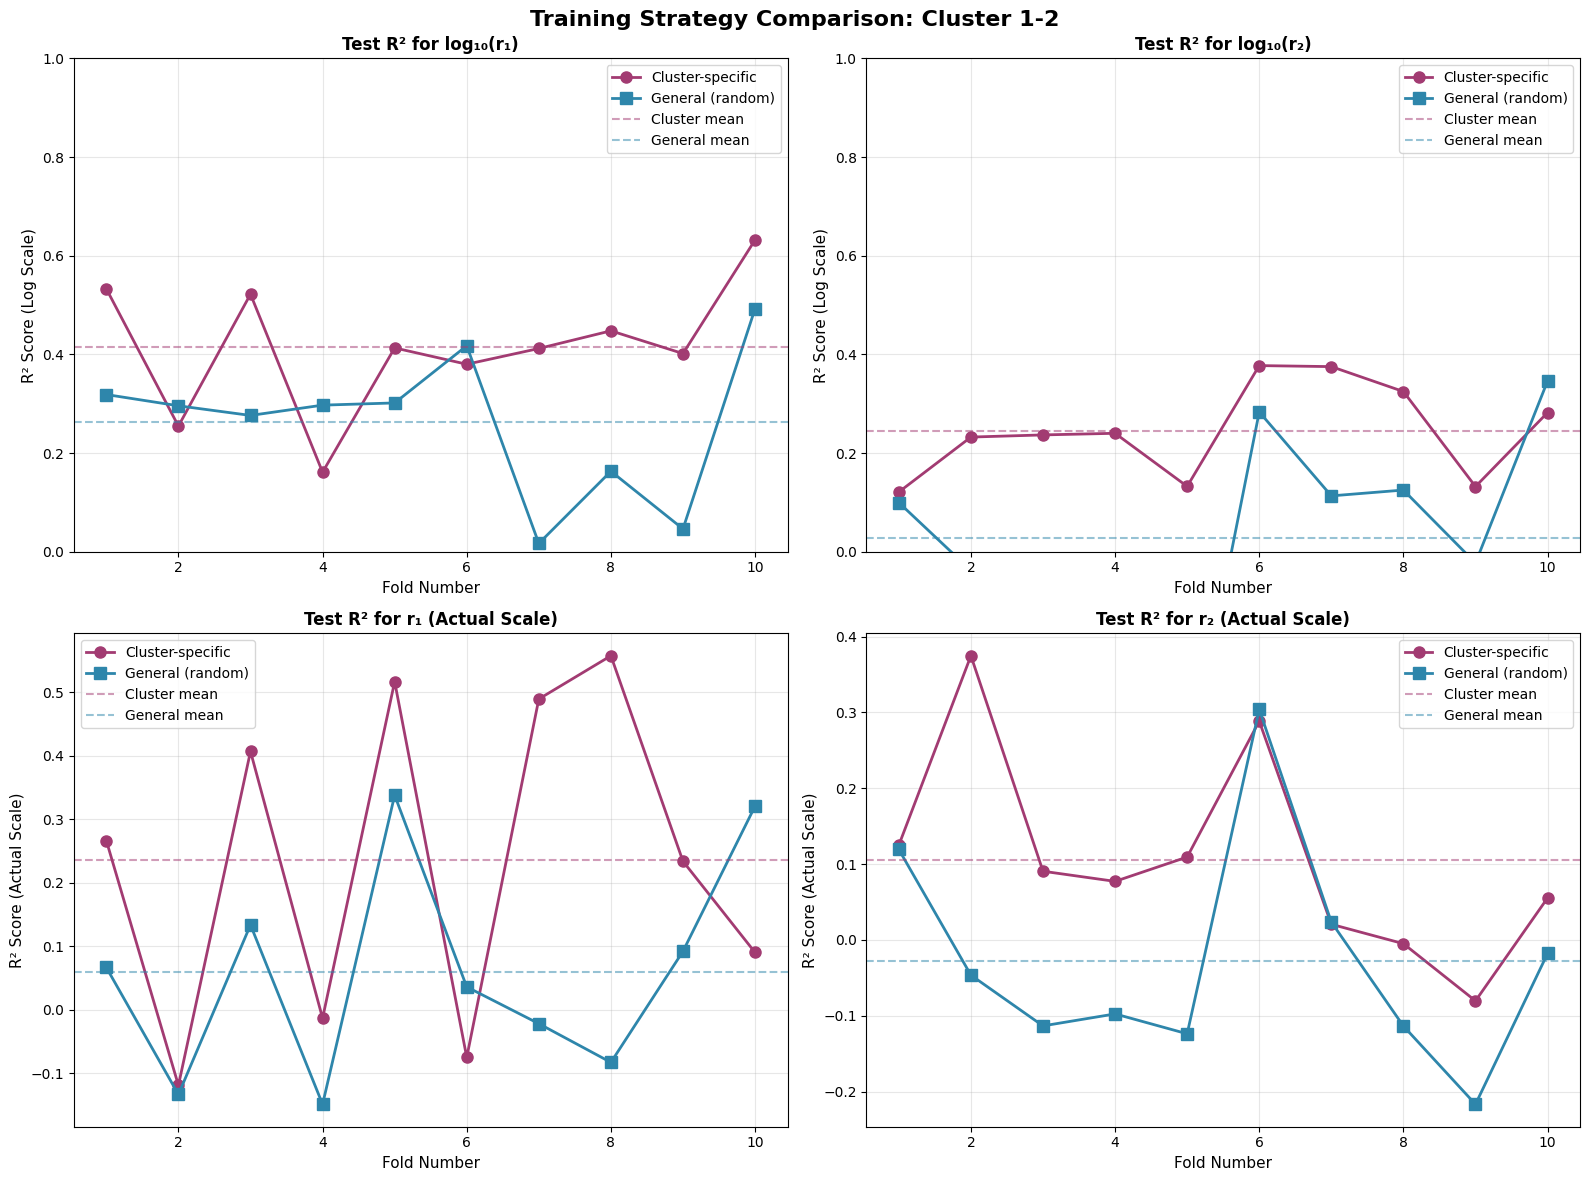

In [4]:
"""
Enhanced Cluster-Specific Training Analysis with Comprehensive Metrics
====================================================================

Compares cluster-specific training vs. general random sampling training
with identical test sets and training set sizes.
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
CONFIG = {
    'morgan_radius': 3,
    'morgan_bits': 2048,
    'neurons_l1': 80,
    'neurons_l2': 40,
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 200,
    'validation_split': 0.1,
    'patience': 30,
    'cv_folds': 10
}

def generate_morgan_fingerprint(smiles):
    """Generate Morgan fingerprint from SMILES string"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)
        
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, CONFIG['morgan_radius'], nBits=CONFIG['morgan_bits']
        )
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)

def prepare_features_and_targets(data_subset):
    """Prepare Morgan fingerprint features and log-transformed targets"""
    # Generate Morgan fingerprints for both monomers
    fp_A = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_A']])
    fp_B = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_B']])
    
    # Concatenate fingerprints
    X = np.concatenate([fp_A, fp_B], axis=1)
    
    # Log-transformed targets
    y_log = np.column_stack([
        np.log10(data_subset['r1'].values),
        np.log10(data_subset['r2'].values)
    ])
    
    # Actual scale targets
    y_actual = np.column_stack([
        data_subset['r1'].values,
        data_subset['r2'].values
    ])
    
    return X.astype(np.float32), y_log.astype(np.float32), y_actual.astype(np.float32)

def create_neural_network(input_dim):
    """Create the neural network architecture (Farajzadehahary et al.)"""
    model = Sequential([
        Dense(CONFIG['neurons_l1'], activation='relu', input_shape=(input_dim,)),
        Dense(CONFIG['neurons_l2'], activation='relu'), 
        Dense(2, activation='linear')  # Output: [log10(r1), log10(r2)]
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_evaluate_model(X_train, y_train_log, X_test, y_test_log, y_test_actual):
    """Train model and return comprehensive evaluation metrics"""
    # Clear previous session
    tf.keras.backend.clear_session()
    
    # Create and train model
    model = create_neural_network(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    history = model.fit(
        X_train, y_train_log,
        epochs=CONFIG['max_epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Make predictions (log scale)
    y_pred_log_test = model.predict(X_test, verbose=0)
    y_pred_log_train = model.predict(X_train, verbose=0)
    
    # Convert to actual scale
    y_pred_actual_test = 10 ** y_pred_log_test
    y_pred_actual_train = 10 ** y_pred_log_train
    
    # Get actual scale training targets
    y_train_actual = 10 ** y_train_log
    
    # Calculate metrics - LOG SCALE
    metrics = {
        # Training metrics - log scale
        'train_mse_log_r1': mean_squared_error(y_train_log[:, 0], y_pred_log_train[:, 0]),
        'train_mse_log_r2': mean_squared_error(y_train_log[:, 1], y_pred_log_train[:, 1]),
        'train_r2_log_r1': r2_score(y_train_log[:, 0], y_pred_log_train[:, 0]),
        'train_r2_log_r2': r2_score(y_train_log[:, 1], y_pred_log_train[:, 1]),
        
        # Test metrics - log scale
        'test_mse_log_r1': mean_squared_error(y_test_log[:, 0], y_pred_log_test[:, 0]),
        'test_mse_log_r2': mean_squared_error(y_test_log[:, 1], y_pred_log_test[:, 1]),
        'test_r2_log_r1': r2_score(y_test_log[:, 0], y_pred_log_test[:, 0]),
        'test_r2_log_r2': r2_score(y_test_log[:, 1], y_pred_log_test[:, 1]),
        
        # Training metrics - actual scale
        'train_mse_actual_r1': mean_squared_error(y_train_actual[:, 0], y_pred_actual_train[:, 0]),
        'train_mse_actual_r2': mean_squared_error(y_train_actual[:, 1], y_pred_actual_train[:, 1]),
        'train_r2_actual_r1': r2_score(y_train_actual[:, 0], y_pred_actual_train[:, 0]),
        'train_r2_actual_r2': r2_score(y_train_actual[:, 1], y_pred_actual_train[:, 1]),
        
        # Test metrics - actual scale
        'test_mse_actual_r1': mean_squared_error(y_test_actual[:, 0], y_pred_actual_test[:, 0]),
        'test_mse_actual_r2': mean_squared_error(y_test_actual[:, 1], y_pred_actual_test[:, 1]),
        'test_r2_actual_r1': r2_score(y_test_actual[:, 0], y_pred_actual_test[:, 0]),
        'test_r2_actual_r2': r2_score(y_test_actual[:, 1], y_pred_actual_test[:, 1])
    }
    
    return metrics, y_pred_log_test, y_pred_actual_test

def print_metrics_table(cluster_stats, general_stats, cluster_name):
    """Print comprehensive metrics comparison table"""
    print("\n" + "=" * 80)
    print(f"COMPREHENSIVE METRICS COMPARISON: {cluster_name}")
    print("=" * 80)
    
    # Create comparison table
    print("\n" + "─" * 80)
    print("LOG SCALE METRICS")
    print("─" * 80)
    
    metrics_log = [
        ('Train MSE Log R1', 'train_mse_log_r1'),
        ('Train MSE Log R2', 'train_mse_log_r2'),
        ('Test MSE Log R1', 'test_mse_log_r1'),
        ('Test MSE Log R2', 'test_mse_log_r2'),
        ('', ''),  # Separator
        ('Train R² Log R1', 'train_r2_log_r1'),
        ('Train R² Log R2', 'train_r2_log_r2'),
        ('Test R² Log R1', 'test_r2_log_r1'),
        ('Test R² Log R2', 'test_r2_log_r2'),
    ]
    
    print(f"{'Metric':<25} {'Cluster-Specific':<25} {'General Training':<25}")
    print("─" * 80)
    
    for metric_name, metric_key in metrics_log:
        if metric_key == '':
            print("─" * 80)
            continue
        cluster_mean = cluster_stats[f'{metric_key}_mean']
        cluster_std = cluster_stats[f'{metric_key}_std']
        general_mean = general_stats[f'{metric_key}_mean']
        general_std = general_stats[f'{metric_key}_std']
        
        print(f"{metric_name:<25} {cluster_mean:.4f} ± {cluster_std:.4f}      "
              f"{general_mean:.4f} ± {general_std:.4f}")
    
    # Actual scale metrics
    print("\n" + "─" * 80)
    print("ACTUAL SCALE METRICS")
    print("─" * 80)
    
    metrics_actual = [
        ('Train MSE Actual R1', 'train_mse_actual_r1'),
        ('Train MSE Actual R2', 'train_mse_actual_r2'),
        ('Test MSE Actual R1', 'test_mse_actual_r1'),
        ('Test MSE Actual R2', 'test_mse_actual_r2'),
        ('', ''),  # Separator
        ('Train R² Actual R1', 'train_r2_actual_r1'),
        ('Train R² Actual R2', 'train_r2_actual_r2'),
        ('Test R² Actual R1', 'test_r2_actual_r1'),
        ('Test R² Actual R2', 'test_r2_actual_r2'),
    ]
    
    print(f"{'Metric':<25} {'Cluster-Specific':<25} {'General Training':<25}")
    print("─" * 80)
    
    for metric_name, metric_key in metrics_actual:
        if metric_key == '':
            print("─" * 80)
            continue
        cluster_mean = cluster_stats[f'{metric_key}_mean']
        cluster_std = cluster_stats[f'{metric_key}_std']
        general_mean = general_stats[f'{metric_key}_mean']
        general_std = general_stats[f'{metric_key}_std']
        
        print(f"{metric_name:<25} {cluster_mean:.4f} ± {cluster_std:.4f}      "
              f"{general_mean:.4f} ± {general_std:.4f}")
    
    # Statistical significance
    print("\n" + "─" * 80)
    print("STATISTICAL SIGNIFICANCE (Paired t-tests)")
    print("─" * 80)
    print(f"{'Metric':<30} {'t-statistic':<15} {'p-value':<15} {'Significant?':<15}")
    print("─" * 80)

def main_analysis(df, cluster_a, cluster_b):
    """
    Main analysis function
    
    Parameters:
    -----------
    df : DataFrame
        Dataset with columns: SMILES_A, SMILES_B, r1, r2, Cluster_A, Cluster_B
    cluster_a : int
        First cluster number (e.g., 1)
    cluster_b : int
        Second cluster number (e.g., 1 for Cluster 1-1, or 2 for Cluster 1-2)
    """
    cluster_name = f"Cluster {cluster_a}-{cluster_b}"
    print(f"\nStarting Analysis for {cluster_name}")
    print("=" * 80)
    
    # Data preparation
    print("Preparing data...")
    data = df.copy()
    
    # Filter for valid data
    data = data[
        (data['r1'] > 0) & (data['r2'] > 0) &
        data['SMILES_A'].notna() & data['SMILES_B'].notna()
    ].reset_index(drop=True)
    
    print(f"Total dataset size after filtering: {len(data)}")
    
    # Extract specific cluster interactions
    cluster_mask = (data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)
    cluster_indices = data.index[cluster_mask].tolist()
    
    print(f"{cluster_name} interactions: {len(cluster_indices)}")
    
    if len(cluster_indices) < 100:
        raise ValueError(f"Insufficient {cluster_name} samples for 10-fold CV (need >100, got {len(cluster_indices)})")
    
    # Prepare features for entire dataset
    print("Generating Morgan fingerprints...")
    X_all, y_log_all, y_actual_all = prepare_features_and_targets(data)
    
    # Cross-validation setup
    kfold = KFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=42)
    
    # Storage for results
    results = {
        'cluster_specific': [],
        'general': []
    }
    
    print(f"\nStarting {CONFIG['cv_folds']}-fold cross-validation...")
    print("─" * 80)
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(kfold.split(cluster_indices)):
        fold_num = fold + 1
        print(f"Processing Fold {fold_num}/{CONFIG['cv_folds']}...")
        
        # Get actual data indices
        cluster_train_indices = [cluster_indices[i] for i in train_idx]
        cluster_test_indices = [cluster_indices[i] for i in test_idx]
        
        # Prepare test set (same for both models)
        X_test = X_all[cluster_test_indices]
        y_test_log = y_log_all[cluster_test_indices]
        y_test_actual = y_actual_all[cluster_test_indices]
        
        # === CLUSTER-SPECIFIC TRAINING ===
        X_cluster_train = X_all[cluster_train_indices]
        y_cluster_train_log = y_log_all[cluster_train_indices]
        
        cluster_metrics, _, _ = train_and_evaluate_model(
            X_cluster_train, y_cluster_train_log, 
            X_test, y_test_log, y_test_actual
        )
        
        # === GENERAL TRAINING (Random sampling with same size) ===
        # Sample random indices excluding test set
        available_indices = [i for i in range(len(data)) if i not in cluster_test_indices]
        general_train_indices = np.random.choice(
            available_indices, 
            size=len(cluster_train_indices), 
            replace=False
        )
        
        X_general_train = X_all[general_train_indices]
        y_general_train_log = y_log_all[general_train_indices]
        
        general_metrics, _, _ = train_and_evaluate_model(
            X_general_train, y_general_train_log,
            X_test, y_test_log, y_test_actual
        )
        
        # Store results
        results['cluster_specific'].append(cluster_metrics)
        results['general'].append(general_metrics)
        
        # Print fold summary
        print(f"  Test size: {len(cluster_test_indices)}, Train size: {len(cluster_train_indices)}")
        print(f"  Cluster R² (log): r1={cluster_metrics['test_r2_log_r1']:.3f}, r2={cluster_metrics['test_r2_log_r2']:.3f}")
        print(f"  General R² (log): r1={general_metrics['test_r2_log_r1']:.3f}, r2={general_metrics['test_r2_log_r2']:.3f}")
        print()
    
    # Calculate statistics
    print("\nCalculating statistics...")
    
    def calculate_cv_stats(metric_list):
        stats_dict = {}
        all_metrics = metric_list[0].keys()
        for metric_name in all_metrics:
            values = np.array([m[metric_name] for m in metric_list])
            stats_dict[f'{metric_name}_mean'] = values.mean()
            stats_dict[f'{metric_name}_std'] = values.std()
        return stats_dict
    
    cluster_stats = calculate_cv_stats(results['cluster_specific'])
    general_stats = calculate_cv_stats(results['general'])
    
    # Print comprehensive table
    print_metrics_table(cluster_stats, general_stats, cluster_name)
    
    # Create visualizations
    create_comparison_plots(results, cluster_stats, general_stats, cluster_name)
    
    return results, cluster_stats, general_stats

def create_comparison_plots(results, cluster_stats, general_stats, cluster_name):
    """Create comprehensive comparison visualizations"""
    
    # Extract fold-wise metrics for plotting
    folds = list(range(1, len(results['cluster_specific']) + 1))
    
    # Prepare data for plotting
    cluster_r2_log_r1 = [m['test_r2_log_r1'] for m in results['cluster_specific']]
    cluster_r2_log_r2 = [m['test_r2_log_r2'] for m in results['cluster_specific']]
    general_r2_log_r1 = [m['test_r2_log_r1'] for m in results['general']]
    general_r2_log_r2 = [m['test_r2_log_r2'] for m in results['general']]
    
    cluster_r2_actual_r1 = [m['test_r2_actual_r1'] for m in results['cluster_specific']]
    cluster_r2_actual_r2 = [m['test_r2_actual_r2'] for m in results['cluster_specific']]
    general_r2_actual_r1 = [m['test_r2_actual_r1'] for m in results['general']]
    general_r2_actual_r2 = [m['test_r2_actual_r2'] for m in results['general']]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Training Strategy Comparison: {cluster_name}', fontsize=16, fontweight='bold')
    
    colors = {'cluster': '#A23B72', 'general': '#2E86AB'}
    
    # Plot 1: R² Log Scale - R1
    axes[0, 0].plot(folds, cluster_r2_log_r1, 'o-', color=colors['cluster'], 
                    label='Cluster-specific', linewidth=2, markersize=8)
    axes[0, 0].plot(folds, general_r2_log_r1, 's-', color=colors['general'], 
                    label='General (random)', linewidth=2, markersize=8)
    axes[0, 0].axhline(y=cluster_stats['test_r2_log_r1_mean'], color=colors['cluster'], 
                       linestyle='--', alpha=0.5, label='Cluster mean')
    axes[0, 0].axhline(y=general_stats['test_r2_log_r1_mean'], color=colors['general'], 
                       linestyle='--', alpha=0.5, label='General mean')
    axes[0, 0].set_xlabel('Fold Number', fontsize=11)
    axes[0, 0].set_ylabel('R² Score (Log Scale)', fontsize=11)
    axes[0, 0].set_title('Test R² for log₁₀(r₁)', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 1)
    
    # Plot 2: R² Log Scale - R2
    axes[0, 1].plot(folds, cluster_r2_log_r2, 'o-', color=colors['cluster'], 
                    label='Cluster-specific', linewidth=2, markersize=8)
    axes[0, 1].plot(folds, general_r2_log_r2, 's-', color=colors['general'], 
                    label='General (random)', linewidth=2, markersize=8)
    axes[0, 1].axhline(y=cluster_stats['test_r2_log_r2_mean'], color=colors['cluster'], 
                       linestyle='--', alpha=0.5, label='Cluster mean')
    axes[0, 1].axhline(y=general_stats['test_r2_log_r2_mean'], color=colors['general'], 
                       linestyle='--', alpha=0.5, label='General mean')
    axes[0, 1].set_xlabel('Fold Number', fontsize=11)
    axes[0, 1].set_ylabel('R² Score (Log Scale)', fontsize=11)
    axes[0, 1].set_title('Test R² for log₁₀(r₂)', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # Plot 3: R² Actual Scale - R1
    axes[1, 0].plot(folds, cluster_r2_actual_r1, 'o-', color=colors['cluster'], 
                    label='Cluster-specific', linewidth=2, markersize=8)
    axes[1, 0].plot(folds, general_r2_actual_r1, 's-', color=colors['general'], 
                    label='General (random)', linewidth=2, markersize=8)
    axes[1, 0].axhline(y=cluster_stats['test_r2_actual_r1_mean'], color=colors['cluster'], 
                       linestyle='--', alpha=0.5, label='Cluster mean')
    axes[1, 0].axhline(y=general_stats['test_r2_actual_r1_mean'], color=colors['general'], 
                       linestyle='--', alpha=0.5, label='General mean')
    axes[1, 0].set_xlabel('Fold Number', fontsize=11)
    axes[1, 0].set_ylabel('R² Score (Actual Scale)', fontsize=11)
    axes[1, 0].set_title('Test R² for r₁ (Actual Scale)', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: R² Actual Scale - R2
    axes[1, 1].plot(folds, cluster_r2_actual_r2, 'o-', color=colors['cluster'], 
                    label='Cluster-specific', linewidth=2, markersize=8)
    axes[1, 1].plot(folds, general_r2_actual_r2, 's-', color=colors['general'], 
                    label='General (random)', linewidth=2, markersize=8)
    axes[1, 1].axhline(y=cluster_stats['test_r2_actual_r2_mean'], color=colors['cluster'], 
                       linestyle='--', alpha=0.5, label='Cluster mean')
    axes[1, 1].axhline(y=general_stats['test_r2_actual_r2_mean'], color=colors['general'], 
                       linestyle='--', alpha=0.5, label='General mean')
    axes[1, 1].set_xlabel('Fold Number', fontsize=11)
    axes[1, 1].set_ylabel('R² Score (Actual Scale)', fontsize=11)
    axes[1, 1].set_title('Test R² for r₂ (Actual Scale)', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'cluster_comparison_{cluster_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
if __name__ == "__main__":
    print("=" * 80)
    print("CLUSTER-SPECIFIC vs GENERAL TRAINING COMPARISON")
    print("=" * 80)
    print("\nTo run analysis for Cluster 1-1:")
    print("results_11, cluster_stats_11, general_stats_11 = main_analysis(df, cluster_a=1, cluster_b=1)")
    print("\nTo run analysis for Cluster 1-2:")
    print("results_12, cluster_stats_12, general_stats_12 = main_analysis(df, cluster_a=1, cluster_b=2)")
    print("\nDataFrame 'df' should contain:")
    print("- SMILES_A, SMILES_B: SMILES strings")
    print("- r1, r2: Reactivity ratios")
    print("- Cluster_A, Cluster_B: Cluster assignments (1, 2, or 3)")

# Run the analysis (example - comment out if not needed)
results, cluster_stats, general_stats = main_analysis(df, cluster_a=1, cluster_b=2)


454


DATA DISTRIBUTION CHECK

Total valid samples: 2304

Cluster Interaction Counts:
  Cluster 1-1: 870 samples
  Cluster 1-2: 858 samples
  Cluster 1-3: 154 samples
  Cluster 2-2: 360 samples
  Cluster 2-3: 52 samples
  Cluster 3-3: 10 samples

STARTING ANALYSIS

ANALYZING Cluster 1-1 INTERACTIONS

Total samples: 870
  - Cluster 1 with Cluster 1: 870
Processing Fold 1...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 2...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 3...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 4...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 5...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 6...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 7...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 8...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 9...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Figure saved: comprehensive_cv_Cluster_1_1.png


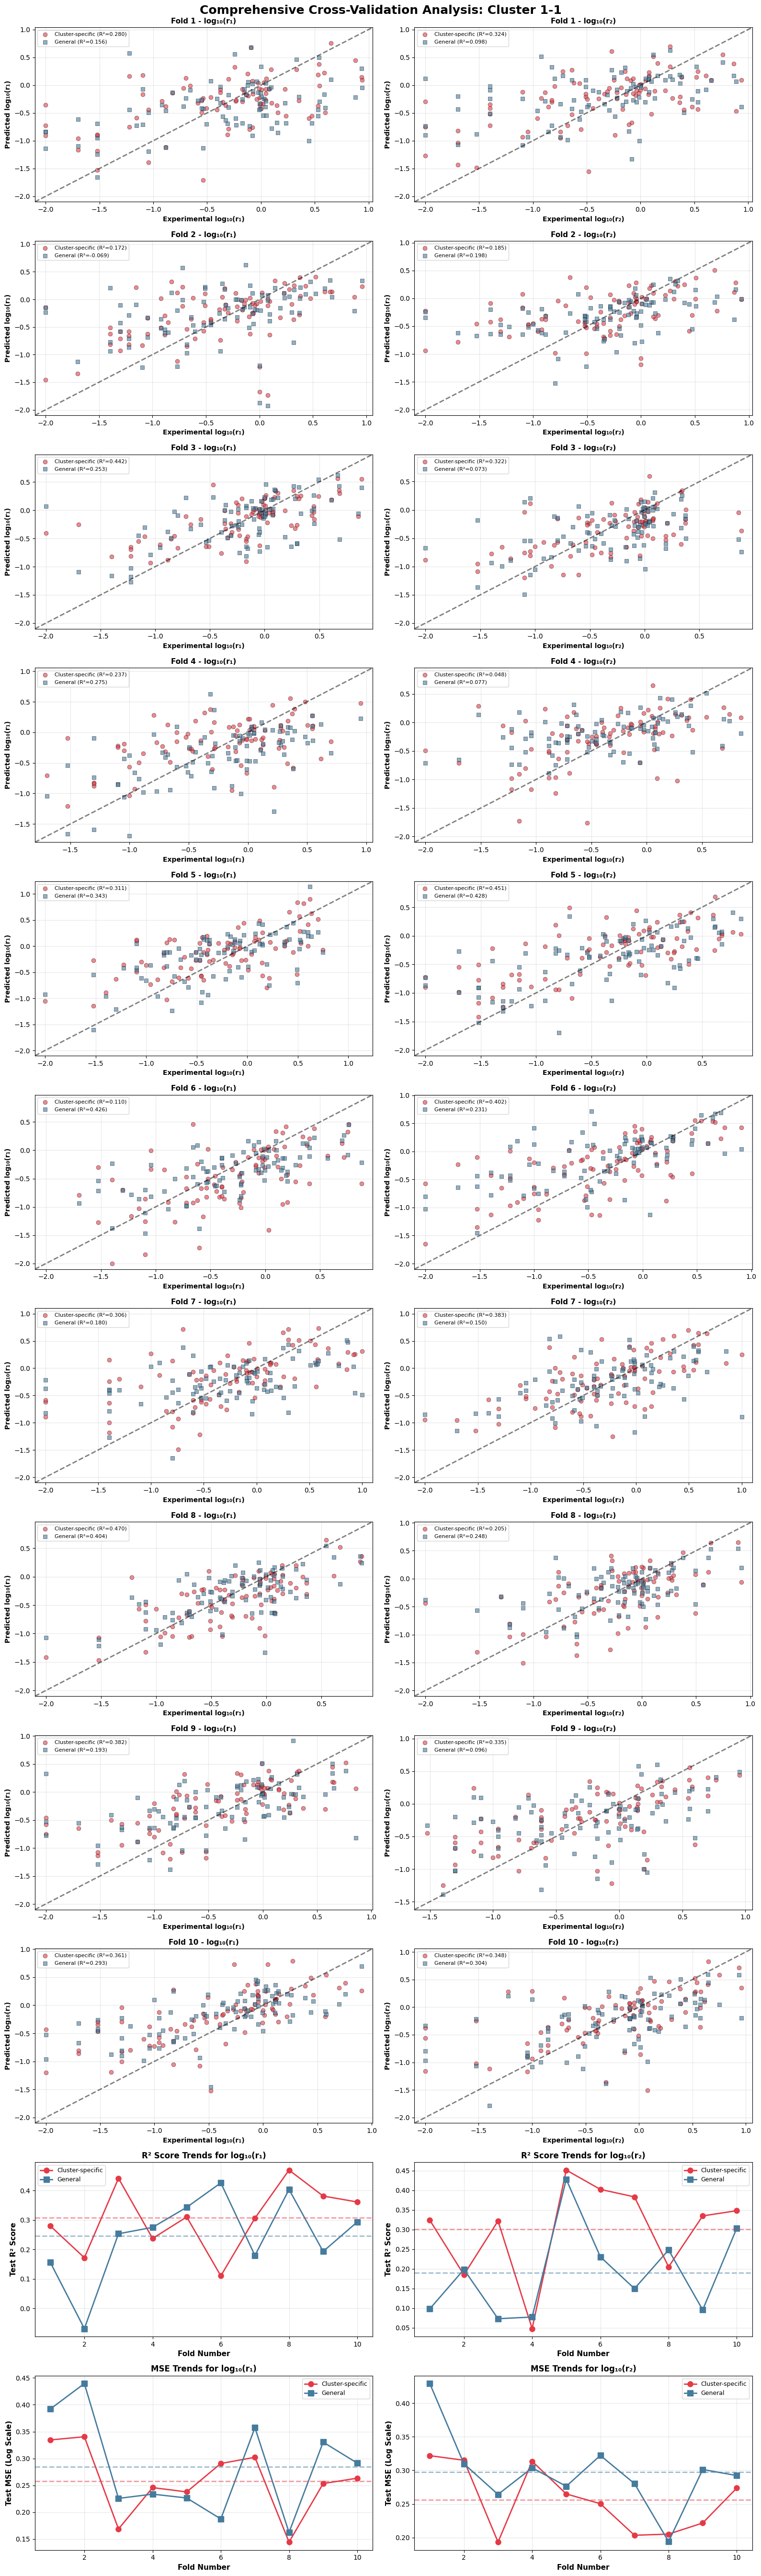


SUMMARY STATISTICS

Average Test R² Score log₁₀(r₁):
  Cluster-specific: 0.3072
  General:          0.2456

Average Test R² Score log₁₀(r₂):
  Cluster-specific: 0.3003
  General:          0.1902

Average Test MSE log₁₀(r₁):
  Cluster-specific: 0.2581
  General:          0.2846

Average Test MSE log₁₀(r₂):
  Cluster-specific: 0.2563
  General:          0.2973


In [9]:
"""
Enhanced Cluster-Specific Training Analysis with Comprehensive Parity Plots
==========================================================================
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

CONFIG = {
    'morgan_radius': 3,
    'morgan_bits': 2048,
    'neurons_l1': 80,
    'neurons_l2': 40,
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 200,
    'validation_split': 0.1,
    'patience': 30,
    'cv_folds': 10
}

def generate_morgan_fingerprint(smiles):
    """Generate Morgan fingerprint from SMILES string"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, CONFIG['morgan_radius'], nBits=CONFIG['morgan_bits']
        )
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)

def prepare_features_and_targets(data_subset):
    """Prepare Morgan fingerprint features and log-transformed targets"""
    fp_A = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_A']])
    fp_B = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_B']])
    X = np.concatenate([fp_A, fp_B], axis=1)
    
    y_log = np.column_stack([
        np.log10(data_subset['r1'].values),
        np.log10(data_subset['r2'].values)
    ])
    
    return X.astype(np.float32), y_log.astype(np.float32)

def create_neural_network(input_dim):
    """Create neural network architecture"""
    model = Sequential([
        Dense(CONFIG['neurons_l1'], activation='relu', input_shape=(input_dim,)),
        Dense(CONFIG['neurons_l2'], activation='relu'), 
        Dense(2, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_predict(X_train, y_train_log, X_test, y_test_log):
    """Train model and return predictions and metrics"""
    tf.keras.backend.clear_session()
    
    model = create_neural_network(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    model.fit(
        X_train, y_train_log,
        epochs=CONFIG['max_epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    y_pred_log = model.predict(X_test, verbose=0)
    
    metrics = {
        'mse_r1': mean_squared_error(y_test_log[:, 0], y_pred_log[:, 0]),
        'mse_r2': mean_squared_error(y_test_log[:, 1], y_pred_log[:, 1]),
        'r2_r1': r2_score(y_test_log[:, 0], y_pred_log[:, 0]),
        'r2_r2': r2_score(y_test_log[:, 1], y_pred_log[:, 1])
    }
    
    return y_pred_log, metrics

def run_cluster_analysis_with_predictions(df, cluster_a, cluster_b):
    """Run analysis and store predictions for visualization"""
    cluster_name = f"Cluster {cluster_a}-{cluster_b}"
    print(f"\n{'='*80}")
    print(f"ANALYZING {cluster_name} INTERACTIONS")
    print(f"{'='*80}\n")
    
    data = df.copy()
    data = data[
        (data['r1'] > 0) & (data['r2'] > 0) &
        data['SMILES_A'].notna() & data['SMILES_B'].notna()
    ].reset_index(drop=True)
    
    # CORRECTED: Capture bidirectional interactions
    if cluster_a == cluster_b:
        # Self-interaction: only need one direction
        cluster_mask = (data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)
    else:
        # Cross-interaction: capture BOTH directions
        cluster_mask = ((data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)) | \
                       ((data['Cluster_A'] == cluster_b) & (data['Cluster_B'] == cluster_a))
    
    cluster_indices = data.index[cluster_mask].tolist()
    
    print(f"Total samples: {len(cluster_indices)}")
    print(f"  - Cluster {cluster_a} with Cluster {cluster_b}: {len(cluster_indices)}")
    
    if len(cluster_indices) < 100:
        print(f"\nWARNING: Insufficient samples for 10-fold CV (need at least 100)")
        return None, None
    
    X_all, y_log_all = prepare_features_and_targets(data)
    
    kfold = KFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=42)
    
    # Storage for all fold results
    fold_data = []
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(kfold.split(cluster_indices)):
        print(f"Processing Fold {fold + 1}...")
        
        cluster_train_indices = [cluster_indices[i] for i in train_idx]
        cluster_test_indices = [cluster_indices[i] for i in test_idx]
        
        X_test = X_all[cluster_test_indices]
        y_test_log = y_log_all[cluster_test_indices]
        
        # Cluster-specific training
        X_cluster_train = X_all[cluster_train_indices]
        y_cluster_train_log = y_log_all[cluster_train_indices]
        
        y_pred_cluster, metrics_cluster = train_and_predict(
            X_cluster_train, y_cluster_train_log, X_test, y_test_log
        )
        
        # General training
        available_indices = [i for i in range(len(data)) if i not in cluster_test_indices]
        general_train_indices = np.random.choice(
            available_indices, 
            size=len(cluster_train_indices), 
            replace=False
        )
        
        X_general_train = X_all[general_train_indices]
        y_general_train_log = y_log_all[general_train_indices]
        
        y_pred_general, metrics_general = train_and_predict(
            X_general_train, y_general_train_log, X_test, y_test_log
        )
        
        # Store results
        fold_data.append({
            'fold': fold + 1,
            'y_test': y_test_log,
            'y_pred_cluster': y_pred_cluster,
            'y_pred_general': y_pred_general,
            'metrics_cluster': metrics_cluster,
            'metrics_general': metrics_general
        })
    
    return fold_data, cluster_name

def create_comprehensive_parity_plot(fold_data, cluster_name):
    """Create 12x2 subplot figure with parity plots, R² trends, and MSE trends"""
    
    fig, axes = plt.subplots(12, 2, figsize=(16, 54))
    fig.suptitle(f'Comprehensive Cross-Validation Analysis: {cluster_name}', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    
    # Rows 1-10: Parity plots for each fold
    for i, fold_info in enumerate(fold_data):
        fold_num = fold_info['fold']
        y_test = fold_info['y_test']
        y_pred_cluster = fold_info['y_pred_cluster']
        y_pred_general = fold_info['y_pred_general']
        
        # Get R² scores
        r2_cluster_r1 = fold_info['metrics_cluster']['r2_r1']
        r2_cluster_r2 = fold_info['metrics_cluster']['r2_r2']
        r2_general_r1 = fold_info['metrics_general']['r2_r1']
        r2_general_r2 = fold_info['metrics_general']['r2_r2']
        
        # Find global min/max for consistent axes
        all_values_r1 = np.concatenate([y_test[:, 0], y_pred_cluster[:, 0], y_pred_general[:, 0]])
        all_values_r2 = np.concatenate([y_test[:, 1], y_pred_cluster[:, 1], y_pred_general[:, 1]])
        
        min_r1, max_r1 = all_values_r1.min() - 0.1, all_values_r1.max() + 0.1
        min_r2, max_r2 = all_values_r2.min() - 0.1, all_values_r2.max() + 0.1
        
        # Left column: r1 parity plot
        ax_r1 = axes[i, 0]
        ax_r1.scatter(y_test[:, 0], y_pred_cluster[:, 0], 
                     alpha=0.6, s=40, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r1:.3f})', edgecolors='black', linewidth=0.5)
        ax_r1.scatter(y_test[:, 0], y_pred_general[:, 0], 
                     alpha=0.6, s=40, color=colors['general'], 
                     label=f'General (R²={r2_general_r1:.3f})', marker='s', edgecolors='black', linewidth=0.5)
        ax_r1.plot([min_r1, max_r1], [min_r1, max_r1], 'k--', linewidth=2, alpha=0.5)
        ax_r1.set_xlim(min_r1, max_r1)
        ax_r1.set_ylim(min_r1, max_r1)
        ax_r1.set_xlabel('Experimental log₁₀(r₁)', fontsize=10, fontweight='bold')
        ax_r1.set_ylabel('Predicted log₁₀(r₁)', fontsize=10, fontweight='bold')
        ax_r1.set_title(f'Fold {fold_num} - log₁₀(r₁)', fontsize=11, fontweight='bold')
        ax_r1.legend(fontsize=8, loc='upper left')
        ax_r1.grid(True, alpha=0.3)
        
        # Right column: r2 parity plot
        ax_r2 = axes[i, 1]
        ax_r2.scatter(y_test[:, 1], y_pred_cluster[:, 1], 
                     alpha=0.6, s=40, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r2:.3f})', edgecolors='black', linewidth=0.5)
        ax_r2.scatter(y_test[:, 1], y_pred_general[:, 1], 
                     alpha=0.6, s=40, color=colors['general'], 
                     label=f'General (R²={r2_general_r2:.3f})', marker='s', edgecolors='black', linewidth=0.5)
        ax_r2.plot([min_r2, max_r2], [min_r2, max_r2], 'k--', linewidth=2, alpha=0.5)
        ax_r2.set_xlim(min_r2, max_r2)
        ax_r2.set_ylim(min_r2, max_r2)
        ax_r2.set_xlabel('Experimental log₁₀(r₂)', fontsize=10, fontweight='bold')
        ax_r2.set_ylabel('Predicted log₁₀(r₂)', fontsize=10, fontweight='bold')
        ax_r2.set_title(f'Fold {fold_num} - log₁₀(r₂)', fontsize=11, fontweight='bold')
        ax_r2.legend(fontsize=8, loc='upper left')
        ax_r2.grid(True, alpha=0.3)
    
    # Extract metrics for trend plots
    folds = [f['fold'] for f in fold_data]
    r2_cluster_r1 = [f['metrics_cluster']['r2_r1'] for f in fold_data]
    r2_general_r1 = [f['metrics_general']['r2_r1'] for f in fold_data]
    r2_cluster_r2 = [f['metrics_cluster']['r2_r2'] for f in fold_data]
    r2_general_r2 = [f['metrics_general']['r2_r2'] for f in fold_data]
    mse_cluster_r1 = [f['metrics_cluster']['mse_r1'] for f in fold_data]
    mse_general_r1 = [f['metrics_general']['mse_r1'] for f in fold_data]
    mse_cluster_r2 = [f['metrics_cluster']['mse_r2'] for f in fold_data]
    mse_general_r2 = [f['metrics_general']['mse_r2'] for f in fold_data]
    
    # Row 11: R² trends across folds
    # Left: R² for r1
    ax_r2_r1 = axes[10, 0]
    ax_r2_r1.plot(folds, r2_cluster_r1, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_r2_r1.plot(folds, r2_general_r1, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_r2_r1.axhline(y=np.mean(r2_cluster_r1), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r1.axhline(y=np.mean(r2_general_r1), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r1.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_r2_r1.set_ylabel('Test R² Score', fontsize=11, fontweight='bold')
    ax_r2_r1.set_title('R² Score Trends for log₁₀(r₁)', fontsize=12, fontweight='bold')
    ax_r2_r1.legend(fontsize=9)
    ax_r2_r1.grid(True, alpha=0.3)
    
    # Right: R² for r2
    ax_r2_r2 = axes[10, 1]
    ax_r2_r2.plot(folds, r2_cluster_r2, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_r2_r2.plot(folds, r2_general_r2, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_r2_r2.axhline(y=np.mean(r2_cluster_r2), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r2.axhline(y=np.mean(r2_general_r2), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r2.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_r2_r2.set_ylabel('Test R² Score', fontsize=11, fontweight='bold')
    ax_r2_r2.set_title('R² Score Trends for log₁₀(r₂)', fontsize=12, fontweight='bold')
    ax_r2_r2.legend(fontsize=9)
    ax_r2_r2.grid(True, alpha=0.3)
    
    # Row 12: MSE trends across folds
    # Left: MSE for r1
    ax_mse_r1 = axes[11, 0]
    ax_mse_r1.plot(folds, mse_cluster_r1, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_mse_r1.plot(folds, mse_general_r1, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_mse_r1.axhline(y=np.mean(mse_cluster_r1), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r1.axhline(y=np.mean(mse_general_r1), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r1.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_mse_r1.set_ylabel('Test MSE (Log Scale)', fontsize=11, fontweight='bold')
    ax_mse_r1.set_title('MSE Trends for log₁₀(r₁)', fontsize=12, fontweight='bold')
    ax_mse_r1.legend(fontsize=9)
    ax_mse_r1.grid(True, alpha=0.3)
    
    # Right: MSE for r2
    ax_mse_r2 = axes[11, 1]
    ax_mse_r2.plot(folds, mse_cluster_r2, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_mse_r2.plot(folds, mse_general_r2, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_mse_r2.axhline(y=np.mean(mse_cluster_r2), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r2.axhline(y=np.mean(mse_general_r2), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r2.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_mse_r2.set_ylabel('Test MSE (Log Scale)', fontsize=11, fontweight='bold')
    ax_mse_r2.set_title('MSE Trends for log₁₀(r₂)', fontsize=12, fontweight='bold')
    ax_mse_r2.legend(fontsize=9)
    ax_mse_r2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    filename = f'comprehensive_cv_{cluster_name.replace(" ", "_").replace("-", "_")}.png'
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: {filename}")
    plt.show()

def main_analysis(df, cluster_a, cluster_b):
    """Main function to run analysis and create visualization"""
    fold_data, cluster_name = run_cluster_analysis_with_predictions(df, cluster_a, cluster_b)
    
    if fold_data is None:
        print(f"\nSkipping {cluster_name} - insufficient data")
        return
    
    create_comprehensive_parity_plot(fold_data, cluster_name)
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"SUMMARY STATISTICS")
    print(f"{'='*80}")
    
    r2_cluster_r1 = np.mean([f['metrics_cluster']['r2_r1'] for f in fold_data])
    r2_general_r1 = np.mean([f['metrics_general']['r2_r1'] for f in fold_data])
    r2_cluster_r2 = np.mean([f['metrics_cluster']['r2_r2'] for f in fold_data])
    r2_general_r2 = np.mean([f['metrics_general']['r2_r2'] for f in fold_data])
    mse_cluster_r1 = np.mean([f['metrics_cluster']['mse_r1'] for f in fold_data])
    mse_general_r1 = np.mean([f['metrics_general']['mse_r1'] for f in fold_data])
    mse_cluster_r2 = np.mean([f['metrics_cluster']['mse_r2'] for f in fold_data])
    mse_general_r2 = np.mean([f['metrics_general']['mse_r2'] for f in fold_data])
    
    print(f"\nAverage Test R² Score log₁₀(r₁):")
    print(f"  Cluster-specific: {r2_cluster_r1:.4f}")
    print(f"  General:          {r2_general_r1:.4f}")
    
    print(f"\nAverage Test R² Score log₁₀(r₂):")
    print(f"  Cluster-specific: {r2_cluster_r2:.4f}")
    print(f"  General:          {r2_general_r2:.4f}")
    
    print(f"\nAverage Test MSE log₁₀(r₁):")
    print(f"  Cluster-specific: {mse_cluster_r1:.4f}")
    print(f"  General:          {mse_general_r1:.4f}")
    
    print(f"\nAverage Test MSE log₁₀(r₂):")
    print(f"  Cluster-specific: {mse_cluster_r2:.4f}")
    print(f"  General:          {mse_general_r2:.4f}")

# Usage
if __name__ == "__main__":
    # Check data distribution before running
    print("="*80)
    print("DATA DISTRIBUTION CHECK")
    print("="*80)
    
    data_check = df.copy()
    data_check = data_check[
        (data_check['r1'] > 0) & (data_check['r2'] > 0) &
        data_check['SMILES_A'].notna() & data_check['SMILES_B'].notna()
    ]
    
    print(f"\nTotal valid samples: {len(data_check)}")
    print("\nCluster Interaction Counts:")
    
    for i in [1, 2, 3]:
        for j in [1, 2, 3]:
            if j >= i:  # Only check upper triangle to avoid duplication
                if i == j:
                    mask = (data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)
                else:
                    mask = ((data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)) | \
                           ((data_check['Cluster_A'] == j) & (data_check['Cluster_B'] == i))
                count = mask.sum()
                print(f"  Cluster {i}-{j}: {count} samples")
    
    print("\n" + "="*80)
    print("STARTING ANALYSIS")
    print("="*80)
    
    # Run analyses
    main_analysis(df, cluster_a=1, cluster_b=1)
    #main_analysis(df, cluster_a=1, cluster_b=2)
    #main_analysis(df, cluster_a=1, cluster_b=3)
    #main_analysis(df, cluster_a=2, cluster_b=2)
    #main_analysis(df, cluster_a=2, cluster_b=3)
    #main_analysis(df, cluster_a=3, cluster_b=3)

DATA DISTRIBUTION CHECK

Total valid samples: 2304

Cluster Interaction Counts:
  Cluster 1-1: 870 samples
  Cluster 1-2: 858 samples
  Cluster 1-3: 154 samples
  Cluster 2-2: 360 samples
  Cluster 2-3: 52 samples
  Cluster 3-3: 10 samples

STARTING ANALYSIS

ANALYZING Cluster 1-1 INTERACTIONS

Total samples: 870
  - Cluster 1 with Cluster 1: 870
Processing Fold 1...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 2...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 3...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 4...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 5...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 6...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 7...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 8...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 9...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Figure saved: comprehensive_cv_Cluster_1_1.png


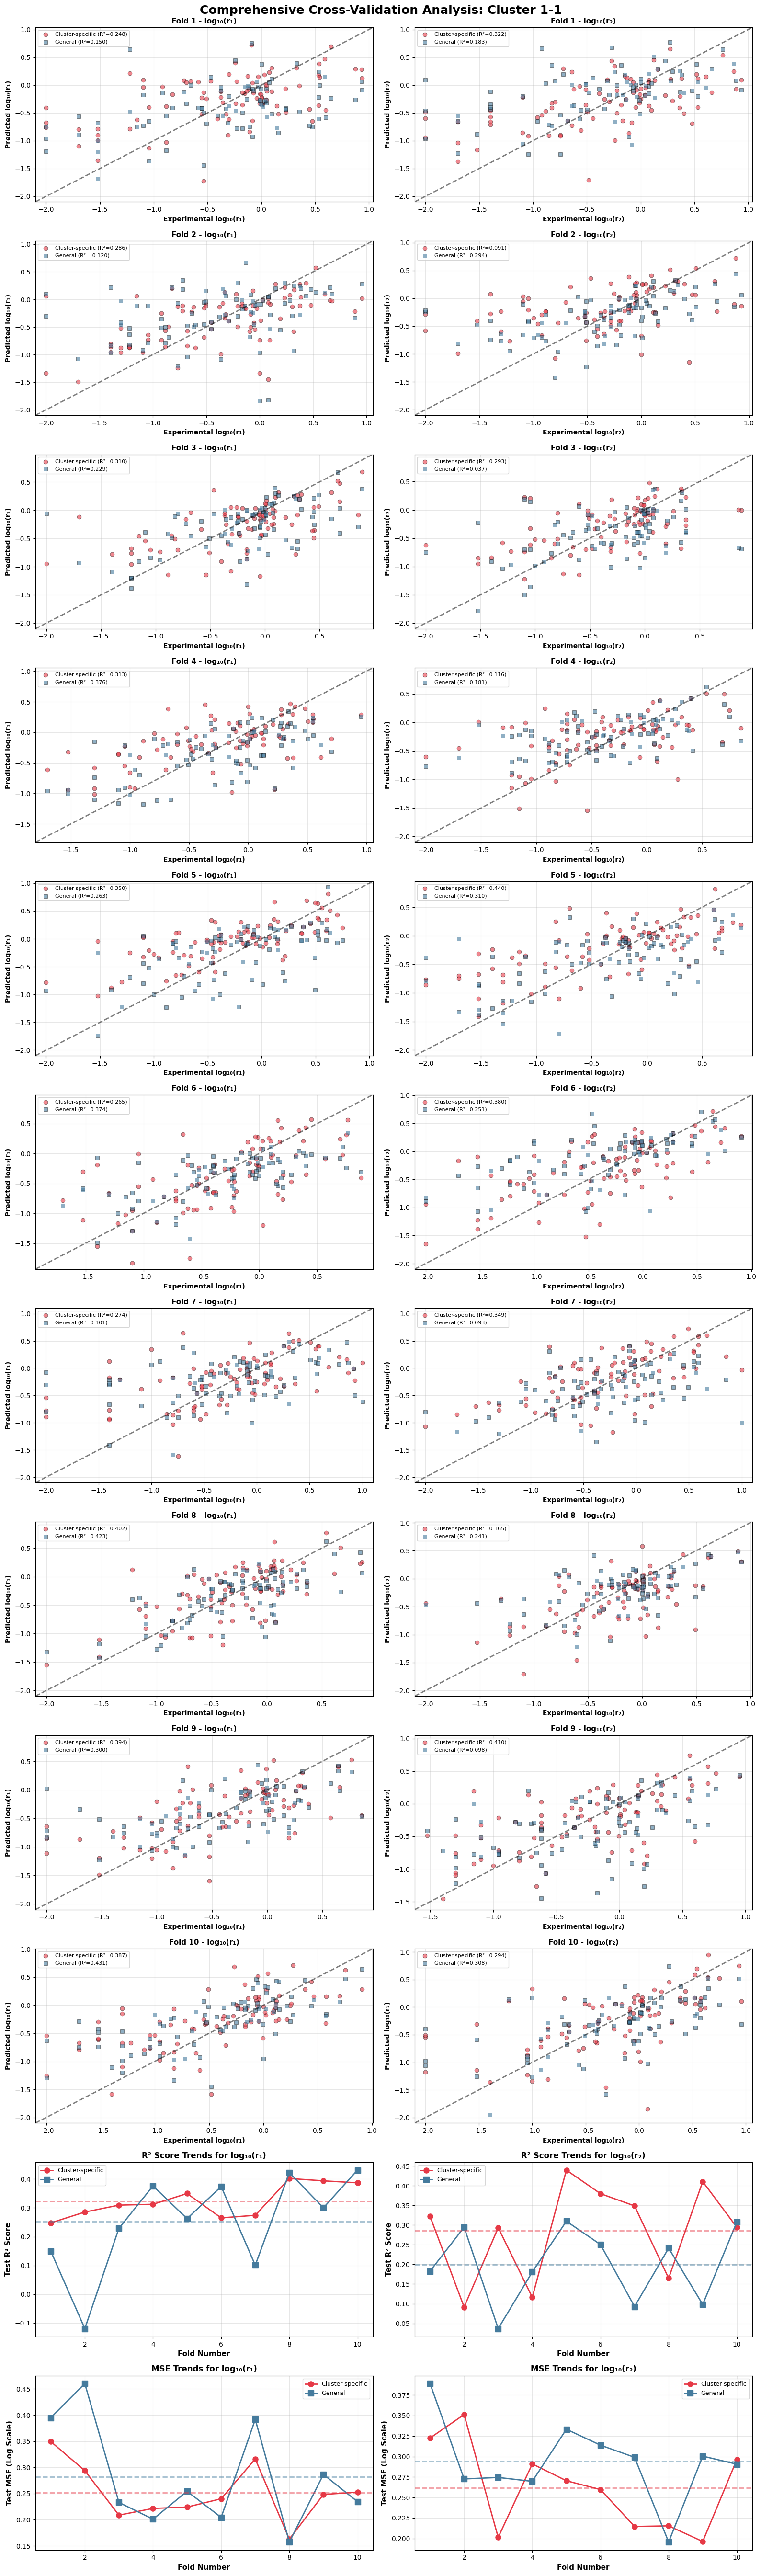


SUMMARY STATISTICS

Average Test R² Score log₁₀(r₁):
  Cluster-specific: 0.3228
  General:          0.2528

Average Test R² Score log₁₀(r₂):
  Cluster-specific: 0.2861
  General:          0.1995

Average Test MSE log₁₀(r₁):
  Cluster-specific: 0.2517
  General:          0.2818

Average Test MSE log₁₀(r₂):
  Cluster-specific: 0.2619
  General:          0.2939

ANALYZING Cluster 1-2 INTERACTIONS

Total samples: 858
  - Cluster 1 with Cluster 2: 858
Processing Fold 1...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 2...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 3...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 4...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 5...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 6...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 7...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 8...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 9...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Figure saved: comprehensive_cv_Cluster_1_2.png


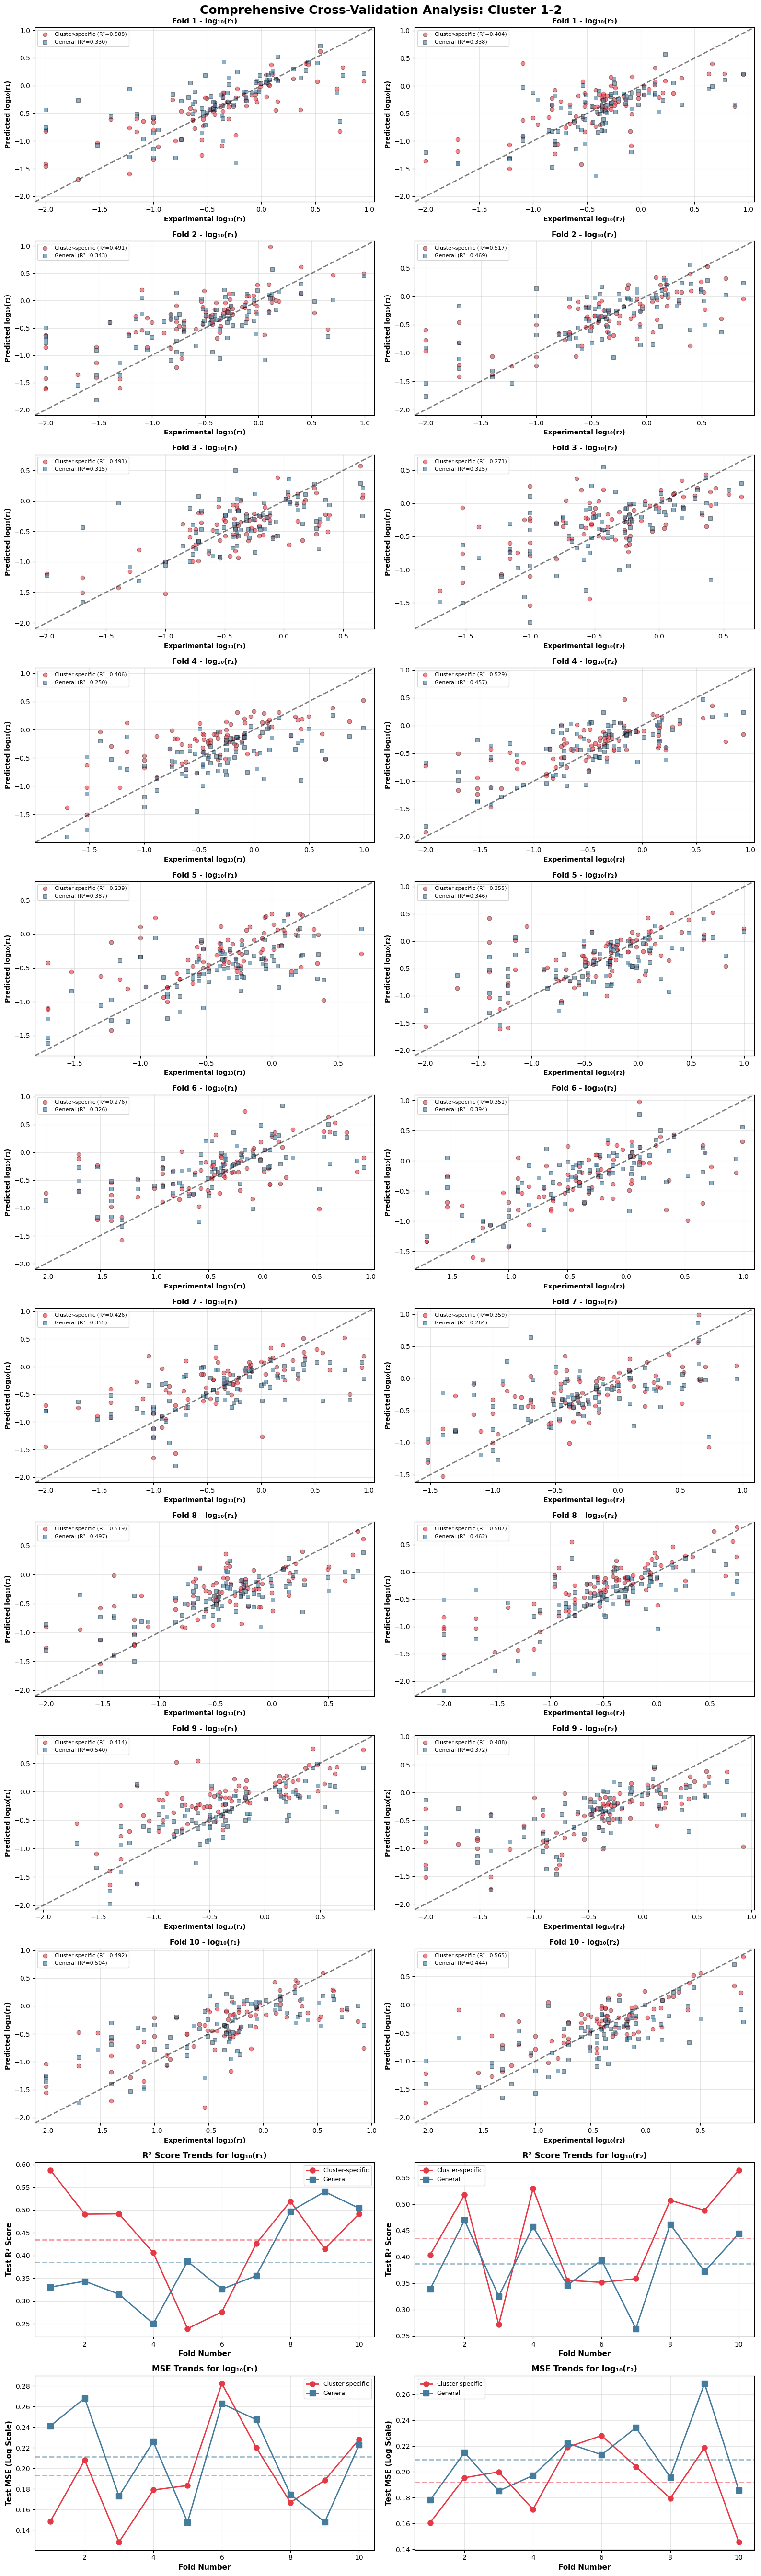


SUMMARY STATISTICS

Average Test R² Score log₁₀(r₁):
  Cluster-specific: 0.4342
  General:          0.3848

Average Test R² Score log₁₀(r₂):
  Cluster-specific: 0.4347
  General:          0.3871

Average Test MSE log₁₀(r₁):
  Cluster-specific: 0.1933
  General:          0.2111

Average Test MSE log₁₀(r₂):
  Cluster-specific: 0.1922
  General:          0.2095

ANALYZING Cluster 2-2 INTERACTIONS

Total samples: 360
  - Cluster 2 with Cluster 2: 360
Processing Fold 1...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 2...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 3...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 4...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 5...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 6...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 7...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 8...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 9...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Figure saved: comprehensive_cv_Cluster_2_2.png


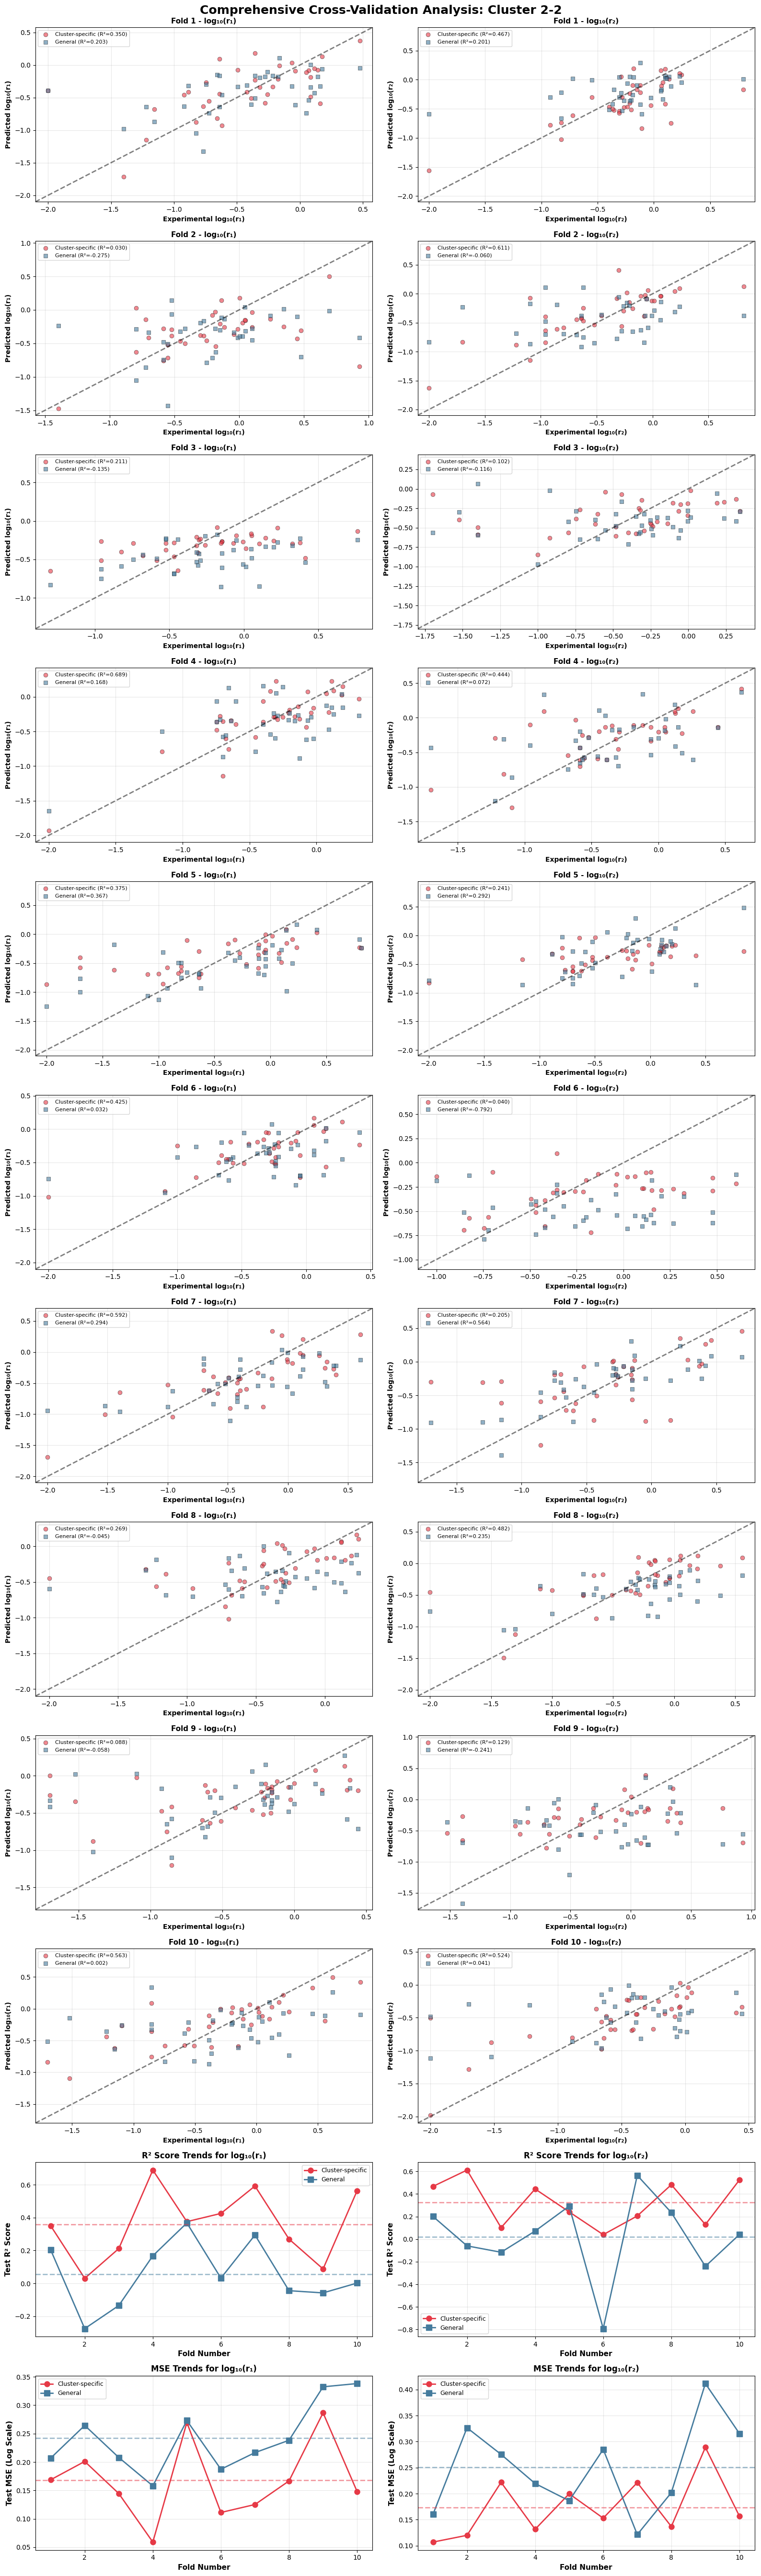


SUMMARY STATISTICS

Average Test R² Score log₁₀(r₁):
  Cluster-specific: 0.3595
  General:          0.0553

Average Test R² Score log₁₀(r₂):
  Cluster-specific: 0.3244
  General:          0.0197

Average Test MSE log₁₀(r₁):
  Cluster-specific: 0.1680
  General:          0.2423

Average Test MSE log₁₀(r₂):
  Cluster-specific: 0.1736
  General:          0.2504


In [16]:
"""
Enhanced Cluster-Specific Training Analysis with Comprehensive Parity Plots
==========================================================================
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

CONFIG = {
    'morgan_radius': 3,
    'morgan_bits': 2048,
    'neurons_l1': 80,
    'neurons_l2': 40,
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 200,
    'validation_split': 0.1,
    'patience': 30,
    'cv_folds': 10
}

def generate_morgan_fingerprint(smiles):
    """Generate Morgan fingerprint from SMILES string"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, CONFIG['morgan_radius'], nBits=CONFIG['morgan_bits']
        )
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)

def prepare_features_and_targets(data_subset):
    """Prepare Morgan fingerprint features and log-transformed targets"""
    fp_A = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_A']])
    fp_B = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_B']])
    X = np.concatenate([fp_A, fp_B], axis=1)
    
    y_log = np.column_stack([
        np.log10(data_subset['r1'].values),
        np.log10(data_subset['r2'].values)
    ])
    
    return X.astype(np.float32), y_log.astype(np.float32)

def create_neural_network(input_dim):
    """Create neural network architecture"""
    model = Sequential([
        Dense(CONFIG['neurons_l1'], activation='relu', input_shape=(input_dim,)),
        Dense(CONFIG['neurons_l2'], activation='relu'), 
        Dense(2, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_predict(X_train, y_train_log, X_test, y_test_log):
    """Train model and return predictions and metrics"""
    tf.keras.backend.clear_session()
    
    model = create_neural_network(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    model.fit(
        X_train, y_train_log,
        epochs=CONFIG['max_epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    y_pred_log = model.predict(X_test, verbose=0)
    
    metrics = {
        'mse_r1': mean_squared_error(y_test_log[:, 0], y_pred_log[:, 0]),
        'mse_r2': mean_squared_error(y_test_log[:, 1], y_pred_log[:, 1]),
        'r2_r1': r2_score(y_test_log[:, 0], y_pred_log[:, 0]),
        'r2_r2': r2_score(y_test_log[:, 1], y_pred_log[:, 1])
    }
    
    return y_pred_log, metrics

def run_cluster_analysis_with_predictions(df, cluster_a, cluster_b):
    """Run analysis and store predictions for visualization"""
    cluster_name = f"Cluster {cluster_a}-{cluster_b}"
    print(f"\n{'='*80}")
    print(f"ANALYZING {cluster_name} INTERACTIONS")
    print(f"{'='*80}\n")
    
    data = df.copy()
    data = data[
        (data['r1'] > 0) & (data['r2'] > 0) &
        data['SMILES_A'].notna() & data['SMILES_B'].notna()
    ].reset_index(drop=True)
    
    # CORRECTED: Capture bidirectional interactions
    if cluster_a == cluster_b:
        # Self-interaction: only need one direction
        cluster_mask = (data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)
    else:
        # Cross-interaction: capture BOTH directions
        cluster_mask = ((data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)) | \
                       ((data['Cluster_A'] == cluster_b) & (data['Cluster_B'] == cluster_a))
    
    cluster_indices = data.index[cluster_mask].tolist()
    
    print(f"Total samples: {len(cluster_indices)}")
    print(f"  - Cluster {cluster_a} with Cluster {cluster_b}: {len(cluster_indices)}")
    
    if len(cluster_indices) < 100:
        print(f"\nWARNING: Insufficient samples for 10-fold CV (need at least 100)")
        return None, None
    
    X_all, y_log_all = prepare_features_and_targets(data)
    
    kfold = KFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=42)
    
    # Storage for all fold results
    fold_data = []
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(kfold.split(cluster_indices)):
        print(f"Processing Fold {fold + 1}...")
        
        cluster_train_indices = [cluster_indices[i] for i in train_idx]
        cluster_test_indices = [cluster_indices[i] for i in test_idx]
        
        X_test = X_all[cluster_test_indices]
        y_test_log = y_log_all[cluster_test_indices]
        
        # Cluster-specific training
        X_cluster_train = X_all[cluster_train_indices]
        y_cluster_train_log = y_log_all[cluster_train_indices]
        
        y_pred_cluster, metrics_cluster = train_and_predict(
            X_cluster_train, y_cluster_train_log, X_test, y_test_log
        )
        
        # General training
        available_indices = [i for i in range(len(data)) if i not in cluster_test_indices]
        general_train_indices = np.random.choice(
            available_indices, 
            size=len(cluster_train_indices), 
            replace=False
        )
        
        X_general_train = X_all[general_train_indices]
        y_general_train_log = y_log_all[general_train_indices]
        
        y_pred_general, metrics_general = train_and_predict(
            X_general_train, y_general_train_log, X_test, y_test_log
        )
        
        # Store results
        fold_data.append({
            'fold': fold + 1,
            'y_test': y_test_log,
            'y_pred_cluster': y_pred_cluster,
            'y_pred_general': y_pred_general,
            'metrics_cluster': metrics_cluster,
            'metrics_general': metrics_general
        })
    
    return fold_data, cluster_name

def create_comprehensive_parity_plot(fold_data, cluster_name):
    """Create 12x2 subplot figure with parity plots, R² trends, and MSE trends"""
    
    fig, axes = plt.subplots(12, 2, figsize=(16, 54))
    fig.suptitle(f'Comprehensive Cross-Validation Analysis: {cluster_name}', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    
    # Rows 1-10: Parity plots for each fold
    for i, fold_info in enumerate(fold_data):
        fold_num = fold_info['fold']
        y_test = fold_info['y_test']
        y_pred_cluster = fold_info['y_pred_cluster']
        y_pred_general = fold_info['y_pred_general']
        
        # Get R² scores
        r2_cluster_r1 = fold_info['metrics_cluster']['r2_r1']
        r2_cluster_r2 = fold_info['metrics_cluster']['r2_r2']
        r2_general_r1 = fold_info['metrics_general']['r2_r1']
        r2_general_r2 = fold_info['metrics_general']['r2_r2']
        
        # Find global min/max for consistent axes
        all_values_r1 = np.concatenate([y_test[:, 0], y_pred_cluster[:, 0], y_pred_general[:, 0]])
        all_values_r2 = np.concatenate([y_test[:, 1], y_pred_cluster[:, 1], y_pred_general[:, 1]])
        
        min_r1, max_r1 = all_values_r1.min() - 0.1, all_values_r1.max() + 0.1
        min_r2, max_r2 = all_values_r2.min() - 0.1, all_values_r2.max() + 0.1
        
        # Left column: r1 parity plot
        ax_r1 = axes[i, 0]
        ax_r1.scatter(y_test[:, 0], y_pred_cluster[:, 0], 
                     alpha=0.6, s=40, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r1:.3f})', edgecolors='black', linewidth=0.5)
        ax_r1.scatter(y_test[:, 0], y_pred_general[:, 0], 
                     alpha=0.6, s=40, color=colors['general'], 
                     label=f'General (R²={r2_general_r1:.3f})', marker='s', edgecolors='black', linewidth=0.5)
        ax_r1.plot([min_r1, max_r1], [min_r1, max_r1], 'k--', linewidth=2, alpha=0.5)
        ax_r1.set_xlim(min_r1, max_r1)
        ax_r1.set_ylim(min_r1, max_r1)
        ax_r1.set_xlabel('Experimental log₁₀(r₁)', fontsize=10, fontweight='bold')
        ax_r1.set_ylabel('Predicted log₁₀(r₁)', fontsize=10, fontweight='bold')
        ax_r1.set_title(f'Fold {fold_num} - log₁₀(r₁)', fontsize=11, fontweight='bold')
        ax_r1.legend(fontsize=8, loc='upper left')
        ax_r1.grid(True, alpha=0.3)
        
        # Right column: r2 parity plot
        ax_r2 = axes[i, 1]
        ax_r2.scatter(y_test[:, 1], y_pred_cluster[:, 1], 
                     alpha=0.6, s=40, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r2:.3f})', edgecolors='black', linewidth=0.5)
        ax_r2.scatter(y_test[:, 1], y_pred_general[:, 1], 
                     alpha=0.6, s=40, color=colors['general'], 
                     label=f'General (R²={r2_general_r2:.3f})', marker='s', edgecolors='black', linewidth=0.5)
        ax_r2.plot([min_r2, max_r2], [min_r2, max_r2], 'k--', linewidth=2, alpha=0.5)
        ax_r2.set_xlim(min_r2, max_r2)
        ax_r2.set_ylim(min_r2, max_r2)
        ax_r2.set_xlabel('Experimental log₁₀(r₂)', fontsize=10, fontweight='bold')
        ax_r2.set_ylabel('Predicted log₁₀(r₂)', fontsize=10, fontweight='bold')
        ax_r2.set_title(f'Fold {fold_num} - log₁₀(r₂)', fontsize=11, fontweight='bold')
        ax_r2.legend(fontsize=8, loc='upper left')
        ax_r2.grid(True, alpha=0.3)
    
    # Extract metrics for trend plots
    folds = [f['fold'] for f in fold_data]
    r2_cluster_r1 = [f['metrics_cluster']['r2_r1'] for f in fold_data]
    r2_general_r1 = [f['metrics_general']['r2_r1'] for f in fold_data]
    r2_cluster_r2 = [f['metrics_cluster']['r2_r2'] for f in fold_data]
    r2_general_r2 = [f['metrics_general']['r2_r2'] for f in fold_data]
    mse_cluster_r1 = [f['metrics_cluster']['mse_r1'] for f in fold_data]
    mse_general_r1 = [f['metrics_general']['mse_r1'] for f in fold_data]
    mse_cluster_r2 = [f['metrics_cluster']['mse_r2'] for f in fold_data]
    mse_general_r2 = [f['metrics_general']['mse_r2'] for f in fold_data]
    
    # Row 11: R² trends across folds
    # Left: R² for r1
    ax_r2_r1 = axes[10, 0]
    ax_r2_r1.plot(folds, r2_cluster_r1, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_r2_r1.plot(folds, r2_general_r1, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_r2_r1.axhline(y=np.mean(r2_cluster_r1), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r1.axhline(y=np.mean(r2_general_r1), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r1.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_r2_r1.set_ylabel('Test R² Score', fontsize=11, fontweight='bold')
    ax_r2_r1.set_title('R² Score Trends for log₁₀(r₁)', fontsize=12, fontweight='bold')
    ax_r2_r1.legend(fontsize=9)
    ax_r2_r1.grid(True, alpha=0.3)
    
    # Right: R² for r2
    ax_r2_r2 = axes[10, 1]
    ax_r2_r2.plot(folds, r2_cluster_r2, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_r2_r2.plot(folds, r2_general_r2, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_r2_r2.axhline(y=np.mean(r2_cluster_r2), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r2.axhline(y=np.mean(r2_general_r2), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_r2_r2.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_r2_r2.set_ylabel('Test R² Score', fontsize=11, fontweight='bold')
    ax_r2_r2.set_title('R² Score Trends for log₁₀(r₂)', fontsize=12, fontweight='bold')
    ax_r2_r2.legend(fontsize=9)
    ax_r2_r2.grid(True, alpha=0.3)
    
    # Row 12: MSE trends across folds
    # Left: MSE for r1
    ax_mse_r1 = axes[11, 0]
    ax_mse_r1.plot(folds, mse_cluster_r1, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_mse_r1.plot(folds, mse_general_r1, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_mse_r1.axhline(y=np.mean(mse_cluster_r1), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r1.axhline(y=np.mean(mse_general_r1), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r1.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_mse_r1.set_ylabel('Test MSE (Log Scale)', fontsize=11, fontweight='bold')
    ax_mse_r1.set_title('MSE Trends for log₁₀(r₁)', fontsize=12, fontweight='bold')
    ax_mse_r1.legend(fontsize=9)
    ax_mse_r1.grid(True, alpha=0.3)
    
    # Right: MSE for r2
    ax_mse_r2 = axes[11, 1]
    ax_mse_r2.plot(folds, mse_cluster_r2, 'o-', color=colors['cluster'], 
                   label='Cluster-specific', linewidth=2, markersize=8)
    ax_mse_r2.plot(folds, mse_general_r2, 's-', color=colors['general'], 
                   label='General', linewidth=2, markersize=8)
    ax_mse_r2.axhline(y=np.mean(mse_cluster_r2), color=colors['cluster'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r2.axhline(y=np.mean(mse_general_r2), color=colors['general'], 
                      linestyle='--', alpha=0.5, linewidth=2)
    ax_mse_r2.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax_mse_r2.set_ylabel('Test MSE (Log Scale)', fontsize=11, fontweight='bold')
    ax_mse_r2.set_title('MSE Trends for log₁₀(r₂)', fontsize=12, fontweight='bold')
    ax_mse_r2.legend(fontsize=9)
    ax_mse_r2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    filename = f'comprehensive_cv_{cluster_name.replace(" ", "_").replace("-", "_")}.png'
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: {filename}")
    plt.show()

def main_analysis(df, cluster_a, cluster_b):
    """Main function to run analysis and create visualization"""
    fold_data, cluster_name = run_cluster_analysis_with_predictions(df, cluster_a, cluster_b)
    
    if fold_data is None:
        print(f"\nSkipping {cluster_name} - insufficient data")
        return
    
    create_comprehensive_parity_plot(fold_data, cluster_name)
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"SUMMARY STATISTICS")
    print(f"{'='*80}")
    
    r2_cluster_r1 = np.mean([f['metrics_cluster']['r2_r1'] for f in fold_data])
    r2_general_r1 = np.mean([f['metrics_general']['r2_r1'] for f in fold_data])
    r2_cluster_r2 = np.mean([f['metrics_cluster']['r2_r2'] for f in fold_data])
    r2_general_r2 = np.mean([f['metrics_general']['r2_r2'] for f in fold_data])
    mse_cluster_r1 = np.mean([f['metrics_cluster']['mse_r1'] for f in fold_data])
    mse_general_r1 = np.mean([f['metrics_general']['mse_r1'] for f in fold_data])
    mse_cluster_r2 = np.mean([f['metrics_cluster']['mse_r2'] for f in fold_data])
    mse_general_r2 = np.mean([f['metrics_general']['mse_r2'] for f in fold_data])
    
    print(f"\nAverage Test R² Score log₁₀(r₁):")
    print(f"  Cluster-specific: {r2_cluster_r1:.4f}")
    print(f"  General:          {r2_general_r1:.4f}")
    
    print(f"\nAverage Test R² Score log₁₀(r₂):")
    print(f"  Cluster-specific: {r2_cluster_r2:.4f}")
    print(f"  General:          {r2_general_r2:.4f}")
    
    print(f"\nAverage Test MSE log₁₀(r₁):")
    print(f"  Cluster-specific: {mse_cluster_r1:.4f}")
    print(f"  General:          {mse_general_r1:.4f}")
    
    print(f"\nAverage Test MSE log₁₀(r₂):")
    print(f"  Cluster-specific: {mse_cluster_r2:.4f}")
    print(f"  General:          {mse_general_r2:.4f}")

# Usage
if __name__ == "__main__":
    # Check data distribution before running
    print("="*80)
    print("DATA DISTRIBUTION CHECK")
    print("="*80)
    
    data_check = df.copy()
    data_check = data_check[
        (data_check['r1'] > 0) & (data_check['r2'] > 0) &
        data_check['SMILES_A'].notna() & data_check['SMILES_B'].notna()
    ]
    
    print(f"\nTotal valid samples: {len(data_check)}")
    print("\nCluster Interaction Counts:")
    
    for i in [1, 2, 3]:
        for j in [1, 2, 3]:
            if j >= i:  # Only check upper triangle to avoid duplication
                if i == j:
                    mask = (data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)
                else:
                    mask = ((data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)) | \
                           ((data_check['Cluster_A'] == j) & (data_check['Cluster_B'] == i))
                count = mask.sum()
                print(f"  Cluster {i}-{j}: {count} samples")
    
    print("\n" + "="*80)
    print("STARTING ANALYSIS")
    print("="*80)
    
    # Run analyses
    main_analysis(df, cluster_a=1, cluster_b=1)
    #main_analysis(df, cluster_a=1, cluster_b=2)
    #main_analysis(df, cluster_a=1, cluster_b=3)
    #main_analysis(df, cluster_a=2, cluster_b=2)
    #main_analysis(df, cluster_a=2, cluster_b=3)
    #main_analysis(df, cluster_a=3, cluster_b=3)